# Direct Least Squares Reconstruction (DLSR) for XRD-CT Using PyTorch

## 📝 Introduction

This notebook provides the **first open-source implementation** of the Direct Least Squares Reconstruction (DLSR) method for X-ray diffraction computed tomography (XRD-CT), implemented entirely in Python using PyTorch with GPU acceleration.

Originally developed and validated using the TOPAS software (Vamvakeros et al., 2020), DLSR was introduced to solve the **parallax artefact** in XRD-CT — a distortion that arises from the depth-dependent shift of Bragg peaks during pencil-beam scanning. Unlike filtered back projection (FBP), which reconstructs image intensities and then fits peaks post hoc, DLSR inverts the full forward model directly in **parameter space** (e.g., peak position, width, amplitude, background), yielding artefact-free maps in a single optimisation step.

Here, we extend the original work by:
- Providing a **fully open-source PyTorch-based implementation**
- Introducing a **neural network model** in place of voxel-wise parameter maps
- Demonstrating improved performance under angular undersampling conditions

## 🎯 Objectives

By the end of this notebook, you will:
- Understand the principle of DLSR and how it differs from conventional FBP-based pipelines
- See how a neural network can be trained to directly reconstruct physical parameter maps from sinogram data
- Compare the results of DLSR to FBP followed by post-reconstruction peak fitting
- Evaluate the robustness of DLSR in cases of angular undersampling (e.g. few projection angles)

## 🧪 Why DLSR?

In conventional XRD-CT workflows:
1. The sinogram is reconstructed (e.g. via FBP)
2. Each voxel's spectrum is then peak-fitted individually

This approach introduces errors if peak shapes or positions are misrepresented due to reconstruction artefacts (especially under parallax or sparse-angle sampling).

**DLSR bypasses this problem** by:
- Treating peak parameters as the direct image to be reconstructed
- Using the known physical forward model to generate sinograms from these parameters
- Optimising parameter values by minimizing the difference between synthetic and experimental sinograms

## 📦 Dataset & Setup

This notebook uses synthetic data representing a 2D phantom with spatially varying peak parameters. The volume is forward-projected to create a sinogram, to which Poisson noise is added.

We then:
- Train a PyTorch model to reconstruct the parameter maps directly from the sinogram
- Compare DLSR output against conventional FBP + peak fitting
- Explore reconstruction accuracy under angular undersampling

Let’s begin by importing the relevant packages and generating the dataset.

## 🧪 Generate Synthetic XRD-CT Phantom and 3D Hyperspectral Volume

We begin by constructing a synthetic 2D spatial phantom composed of five components. These spatial maps (`im1`–`im5`) are used to define the spatially varying parameters of a single diffraction peak with linear background.

### 🏗️ Steps:

1. **Define the diffraction domain**:
   - The variable `x` represents the diffraction axis (e.g., 2θ or q-space), sampled from 0 to 5 in steps of 0.25.

2. **Assign parameter ranges**:
   - `peak_area`, `peak_position`, and `peak_fwhm` define the Gaussian peak.
   - `peak_slope` and `peak_intercept` define the background.
   - Each parameter is mapped from a phantom image and scaled linearly within its physical range.

3. **Construct the volume**:
   - A full 3D volume `vol` is generated where each voxel contains a 1D spectrum (Gaussian + linear background).
   - Padding is applied around the spatial edges to avoid artefacts at boundaries.

4. **Prepare for forward projection**:
   - The volume is reshaped and converted into a PyTorch tensor (`yobs`) on the GPU.
   - Tensor dimensions are permuted into the expected format: `(batch, channels, height, width)`.

This synthetic dataset represents an ideal, ground-truth volume. It will later be forward-projected to simulate sinograms for DLSR training and evaluation.

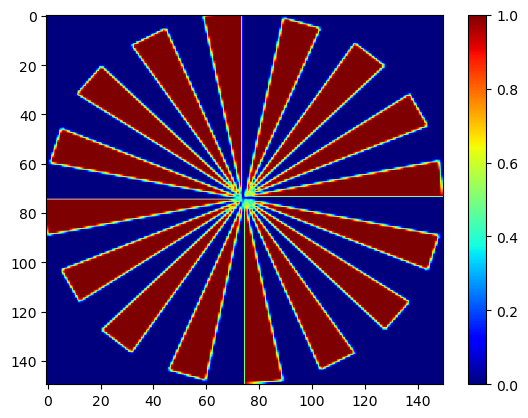

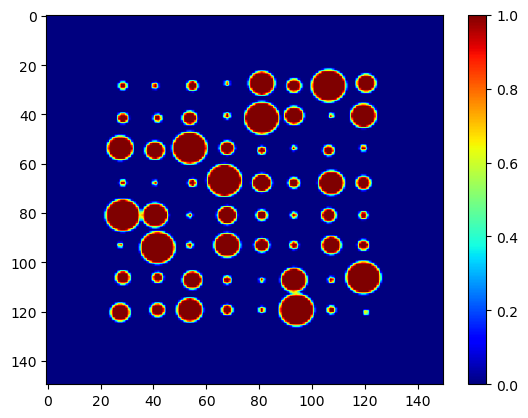

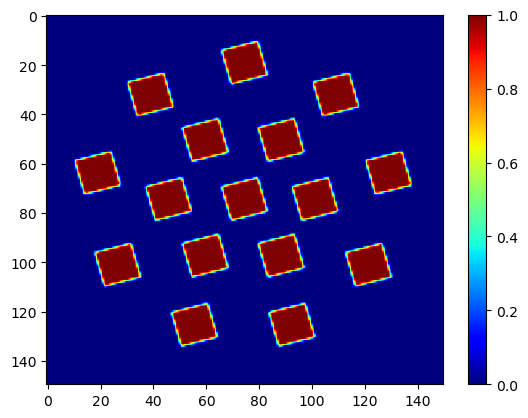

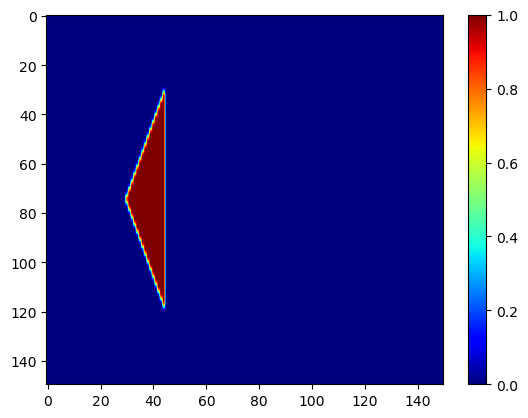

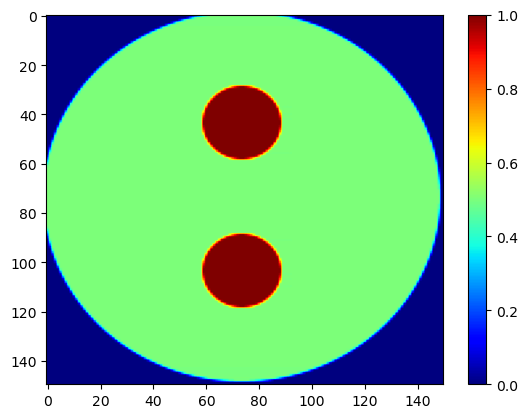

100%|██████████| 150/150 [00:00<00:00, 710.19it/s]

(160, 160, 20) 1.5
torch.Size([1, 20, 160, 160])


In [2]:

from nDTomo.sim.phantoms import load_example_patterns, nDTomophantom_2D, nDTomophantom_3D
from nDTomo.methods.plots import showspectra, showim
from nDTomo.methods.noise import addpnoise3D
from nDTomo.pytorch.tomo_torch import forward_project_3D
from nDTomo.pytorch.models_torch import PeakFitCNN, PrmCNN2D
from nDTomo.pytorch.utils_torch import calc_patches_indices, denormalize, filter_patch_indices, update_counter, initialize_counter, calc_patches_indices

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch, time
import torch.nn.functional as F
from torch import nn

# Create 2D spatial images for the five components
npix = 150
im1, im2, im3, im4, im5 = nDTomophantom_2D(npix, nim='Multiple')
iml = [im1, im2, im3, im4, im5]

im5 = im5/np.max(im5)

%matplotlib inline

# Optionally display spatial maps
showim(im1, 2)
showim(im2, 3)
showim(im3, 4)
showim(im4, 5)
showim(im5, 6)


def linear_background(x, slope, intercept):
    return slope*x + intercept

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2*sigma**2))

# Define the x axis
x = np.arange(0, 5, 0.25)

# Define the min/max for the various parameters

peak1_mu_min = 2
peak1_mu_max = 3

peak1_sigma_min = 0.2
peak1_sigma_max = 0.4

peak1_A_min = 0
peak1_A_max = 1.25

bkg_slope_min = 0.0
bkg_slope_max = 0.025

bkg_intercept_min = 0.05
bkg_intercept_max = 0.25

im6 = im2 + im5
im6 = im6 / np.max(im6)

peak_area = peak1_A_min + im6*(peak1_A_max - peak1_A_min)
peak_position = peak1_mu_min + im2*(peak1_mu_max - peak1_mu_min)
peak_fwhm = peak1_sigma_min + im3*(peak1_sigma_max - peak1_sigma_min)
peak_slope = bkg_slope_min + im4*(bkg_slope_max - bkg_slope_min)
peak_intercept = bkg_intercept_min + im5*(bkg_intercept_max - bkg_intercept_min)

vol = np.zeros((im1.shape[0], im1.shape[1], len(x)), dtype = 'float32')

mask_tmp = np.copy(peak_area)
mask_tmp[mask_tmp<0.0001] = 0
mask_tmp[mask_tmp>0] = 1

for ii in tqdm(range(im1.shape[0])):
    for jj in range(im1.shape[1]):
        if mask_tmp[ii,jj] > 0:
            vol[ii,jj,:] = gaussian(x, A=peak_area[ii,jj], mu=peak_position[ii,jj], sigma=peak_fwhm[ii,jj]) + \
                           linear_background(x, slope=peak_slope[ii,jj], intercept=peak_intercept[ii,jj])

extra = 5
vol = np.concatenate((np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32'), vol, np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32')), axis=1)
vol = np.concatenate((np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32'), vol, np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32')), axis=0)

print(vol.shape, np.max(vol))

volp = np.copy(vol)

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device='cuda')
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)#[0,:,:,:]
print(yobs.shape)


## 📡 Forward Project Synthetic Volume to Generate Noisy Sinogram

In this step, we simulate the **experimental acquisition process** by projecting the 3D synthetic volume onto a set of projection angles, thereby generating a sinogram. This sinogram will serve as the input to both the DLSR and FBP-based reconstruction pipelines.

### 🔧 Forward Projection

- The `forward_project_3D()` function computes parallel-beam projections of the hyperspectral volume (`yobs`) for a specified set of angles.
- Each projection corresponds to a linear integral along a direction in the `(x, y)` plane, for each spectral channel.

Here we simulate:
- A **sparse angular acquisition** using only `60` projection angles between 0° and 180° (undersampled regime).
- This mimics realistic conditions where scan time or radiation dose must be minimized.

### 🌫️ Add Poisson Noise

- Poisson noise is added to the sinogram (`sn`) using `addpnoise3D()` to emulate photon-counting statistics at moderate exposure (`ct=100`).

### 🔁 FBP Baseline (for Comparison)

- As a baseline, we apply **Filtered Back Projection (FBP)** to the noisy sinogram using `astra_rec_vol()`.
- This yields a reconstructed hyperspectral volume (`r`) from which conventional peak fitting will be performed later.

This step prepares both the noisy sinogram and its conventional reconstruction, which will serve as inputs for downstream analysis and comparisons.

In [296]:
from nDTomo.tomo.astra_tomo import astra_rec_vol

angles = np.linspace(0, 180, 180, endpoint=False)
angles = np.linspace(0, 180, 60, endpoint=False)

# print(angles)
s = forward_project_3D(yobs, angles, npix=yobs.shape[2], nch=yobs.shape[1], device='cuda')

sn = s.cpu().detach().numpy()
sn = np.transpose(sn, (2,1,0))
sn = np.transpose(sn, (1,0,2))
sn = addpnoise3D(sn, ct=100)

print(s.shape)
r = astra_rec_vol(sn, theta=np.deg2rad(angles))
r[r<0] = 0

100%|██████████| 20/20 [00:00<00:00, 1780.45it/s]


torch.Size([20, 160, 60])


100%|██████████| 20/20 [00:00<00:00, 156.92it/s]


## 🧠 Define Parameter Model for DLSR and Create Volume Mask

This section defines the parameter model used for DLSR reconstruction and prepares a spatial mask to constrain the optimisation.

### 🔧 Parameter Model (PrmCNN2D)

We use the `PrmCNN2D` module in **parameter-map-only mode**, where each peak and background parameter is initialized as a learnable 2D tensor:
- `num_peaks = 1` → Area, Position, FWHM
- Background terms: Slope and Intercept
- `total_params = 5` maps per voxel

The model holds `npix × npix × total_params` parameters, directly optimised to match observed sinogram projections.

This forms the core of the **DLSR approach**, where optimisation is done directly in parameter space.

### 🛡️ Circular Volume Mask

To avoid boundary artefacts and reduce overfitting at the edges:
- A **circular mask** is applied to the 3D volume (`maskvol`)
- This restricts the optimisation to the central region of the sample, which typically corresponds to valid illumination in experimental geometries

The helper function `create_vol_mask()`:
- Constructs a 3D binary mask using `cirmask()`
- Applies it across all spectral channels
- Converts it to a PyTorch tensor on the correct device

This mask will later be used to ensure that the DLSR loss is only computed in relevant regions of the volume.

In [300]:

npix_x = volp.shape[0]
npix_y = volp.shape[1]
xv = torch.tensor(x, dtype=torch.float32, device='cuda')

### Single peak
peak_definitions = [(1, 1.0, 4.0)]

num_peaks = len(peak_definitions)
num_params_per_peak = 3  # Area, Position, FWHM
background_params = 2  # Slope, Intercept
total_params = num_peaks * num_params_per_peak + background_params

npix = volp.shape[0]
nch_in = total_params
nch_out = total_params
nfilts = 2*total_params # 2*total_params is pretty good when using norm layer
norm_type='layer'
activation='Sigmoid'
downsampling = 8
device = 'cuda'

model = PrmCNN2D(npix, nch_in=nch_in, nch_out=nch_out, nfilts=nfilts, nlayers=1, norm_type='None',
               prms_layer=True, cnn_layer=False, tensor_vals = 'zeros').to(device)
model_prms = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {model_prms}")
print("Conventional number of parameters:", npix*npix*total_params)


def cirmask(im, npx=0):
    """
    Apply a circular mask to the image
    """
    sz = np.floor(im.shape[0])
    x = np.arange(0,sz)
    x = np.tile(x,(int(sz),1))
    y = np.swapaxes(x,0,1)
    xc = np.round(sz/2)
    yc = np.round(sz/2)
    r = np.sqrt(((x-xc)**2 + (y-yc)**2));
    dim =  im.shape
    if len(dim)==2:
        im = np.where(r>np.floor(sz/2) - npx,0,im)
    elif len(dim)==3:
        for ii in range(0,dim[2]):
            im[:,:,ii] = np.where(r>np.floor(sz/2) - npx ,0,im[:,:,ii])
    return(im)

def create_vol_mask(npix, nbins, npx=0):
    mask = np.ones((npix, npix, nbins))
    mask = cirmask(mask,npx)
    mask = np.float32(mask)
    mask = np.transpose(mask, (2,1,0))
    mask = torch.from_numpy(mask)
    mask = torch.reshape(mask, (1, mask.shape[0], mask.shape[1], mask.shape[2]))
    mask = mask.to(device)
    return(mask)

maskvol = create_vol_mask(npix, len(x), npx=0)
print(maskvol.shape)


Total number of parameters: 128000
Conventional number of parameters: 128000
torch.Size([1, 20, 160, 160])


## 🔁 DLSR Training: Direct Least Squares Optimisation in Parameter Space

This section performs the core DLSR reconstruction. We directly optimise the peak and background parameter maps (stored in the `PrmCNN2D` model) to **minimise the discrepancy between the experimental sinogram and the forward projection of the estimated volume**.

### 🧠 Objective

Rather than reconstructing spectra and fitting peaks afterward (as in FBP), DLSR treats the parameters of the peak model as the image to be reconstructed. The pipeline:

1. Converts the predicted parameter maps into a synthetic volume via:
   - Gaussian peak generation
   - Linear background addition
2. Applies the same forward projection operator used to simulate the measured sinogram
3. Compares the synthetic sinogram (`s_gen`) with the observed noisy sinogram (`s`)
4. Minimises the difference (RMSE) using gradient descent on the parameter maps

### ⚙️ Configuration

- **Parameter bounds** (`param_min`/`param_max`) constrain the optimization space for physical realism
- A soft clamp (±20%) is applied around the local average of each map to improve numerical stability during training
- The reconstructed volume is masked using `maskvol` to restrict fitting to valid regions
- The model is trained using **PyTorch with GPU acceleration**, using:
  - Adam optimizer
  - L1, MSE, and RMSE loss metrics (RMSE used for backprop)
  - `ReduceLROnPlateau` scheduler with early stopping

### 🔄 Training Loop Summary

For each epoch:
- Reconstruct the 3D hyperspectral volume from the current parameter maps
- Forward-project this volume into sinogram space
- Compare with the observed sinogram
- Update parameter maps via backpropagation

The loop stops automatically if the learning rate reaches its minimum value, or continues for up to 50,000 epochs.


### 📈 Output

At the end of training, the notebook prints:
- Final values for MAE, MSE, and RMSE
- Total number of epochs run
- Total training time

This concludes the DLSR training stage, resulting in directly reconstructed peak parameter maps that we can now visualize and compare to conventional results.

In [ ]:

def gaussian(x, area, position, fwhm):
    """Gaussian peak shape."""
    return area * torch.exp(-(x - position)**2 / (2 * fwhm**2))
    
MAE = torch.nn.L1Loss()

### Single peak ###
param_min = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Position': torch.tensor([peak[1] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.1,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Slope': torch.zeros(1, dtype=torch.float32).to(device),
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device),
}
param_max = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 2,
    'Position': torch.tensor([peak[2] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.5,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 1,
    'Slope': torch.zeros(1, dtype=torch.float32).to(device) + 0.2,
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device) + 0.5,
}    


nch = volp.shape[2]
im_static = np.sum(volp, axis=2)
im_static = im_static/np.max(im_static)
im_static = np.reshape(im_static, (1, 1, volp.shape[1], volp.shape[1]))
im_static = torch.tensor(im_static, dtype=torch.float32, device=device)

epochs = 2000
patience = 100 #250
min_lr = 1E-5
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
prf = 0.2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr)

start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    yc = model(im_static)

    filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(yc)
    lower_bound = filtered * (1 - prf)
    upper_bound = filtered * (1 + prf)
    yc = torch.clamp(yc, min=lower_bound, max=upper_bound)

    y = torch.zeros((npix*npix, len(xv)), dtype=torch.float32).to(device)
    for i in range(num_peaks):
        
        area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
        position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
        fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

        area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
        position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
        fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

        area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
        position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
        fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
        
        y += gaussian(xv.unsqueeze(0), area, position, fwhm)

    slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
    intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

    slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
    intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

    slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
    intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

    y += slope * xv + intercept  
    y = torch.reshape(y, (1, npix, npix, nch))
    y = torch.transpose(y, 3, 1)
    y = torch.transpose(y, 3, 2)
    y = y*maskvol

    s_gen = forward_project_3D(y, angles, npix=yobs.shape[2], nch=yobs.shape[1], device='cuda')


    loss_mae =  MAE(s, s_gen)
    loss_mse = torch.mean((s - s_gen) ** 2)
    loss_rmse = torch.sqrt(torch.mean((s - s_gen) ** 2))
    
    loss = loss_rmse 
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
                
    logloss.append(loss.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch %  (int(patience/2)) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)

  0%|          | 4/2000 [00:00<02:02, 16.27it/s]

MAE =  tensor(56.6420, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(4978.8784, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(70.5612, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  70.561165


  3%|▎         | 54/2000 [00:03<02:02, 15.92it/s]

MAE =  tensor(4.2871, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(36.6688, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(6.0555, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  6.055481


  5%|▌         | 104/2000 [00:06<01:56, 16.33it/s]

MAE =  tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(2.7614, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(1.6618, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  1.6617591


  8%|▊         | 154/2000 [00:09<01:54, 16.13it/s]

MAE =  tensor(0.7332, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(1.0405, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(1.0200, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  1.0200357


 10%|█         | 204/2000 [00:12<01:47, 16.66it/s]

MAE =  tensor(0.5492, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.6377, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.7985, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.7985431


 13%|█▎        | 254/2000 [00:15<01:46, 16.45it/s]

MAE =  tensor(0.4481, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.4482, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.6695, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.6694673


 15%|█▌        | 304/2000 [00:18<01:46, 15.94it/s]

MAE =  tensor(0.3913, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.3633, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.6027, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.6027267


 18%|█▊        | 352/2000 [00:21<01:44, 15.80it/s]

MAE =  tensor(0.3509, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.3061, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.5533, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.5532962


 20%|██        | 404/2000 [00:25<01:39, 16.05it/s]

MAE =  tensor(0.3207, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.2696, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.5192, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.51919574


 23%|██▎       | 454/2000 [00:28<01:34, 16.34it/s]

MAE =  tensor(0.3046, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.2493, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4993, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.4993489


 25%|██▌       | 504/2000 [00:31<01:33, 16.01it/s]

MAE =  tensor(0.2962, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.2384, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4883, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.4883059


 28%|██▊       | 552/2000 [00:34<01:29, 16.24it/s]

MAE =  tensor(0.2790, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.2178, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4667, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.46672353


 30%|███       | 604/2000 [00:37<01:28, 15.83it/s]

MAE =  tensor(0.2615, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1970, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4439, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.44388604


 33%|███▎      | 654/2000 [00:40<01:25, 15.77it/s]

MAE =  tensor(0.2471, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1827, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4274, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.42740083


 35%|███▌      | 704/2000 [00:43<01:18, 16.43it/s]

MAE =  tensor(0.2517, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1855, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4308, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.43075112


 38%|███▊      | 754/2000 [00:46<01:13, 17.00it/s]

MAE =  tensor(0.2308, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1654, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4067, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.40671772


 40%|████      | 804/2000 [00:49<01:11, 16.69it/s]

MAE =  tensor(0.2331, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1659, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4073, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.40727848


 43%|████▎     | 854/2000 [00:52<01:09, 16.46it/s]

MAE =  tensor(0.2246, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1584, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3980, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3979629


 45%|████▌     | 904/2000 [00:55<01:08, 15.94it/s]

MAE =  tensor(0.2205, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1548, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3934, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.39344025


 48%|████▊     | 954/2000 [00:58<01:03, 16.41it/s]

MAE =  tensor(0.2185, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1527, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3908, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3908297


 50%|█████     | 1004/2000 [01:01<01:00, 16.40it/s]

MAE =  tensor(0.2147, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1494, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3865, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.38653916


 53%|█████▎    | 1054/2000 [01:05<00:59, 15.92it/s]

MAE =  tensor(0.2096, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1451, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3809, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3808833


 55%|█████▌    | 1104/2000 [01:08<00:53, 16.66it/s]

MAE =  tensor(0.2071, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1430, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3782, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3781569


 58%|█████▊    | 1154/2000 [01:11<00:52, 16.00it/s]

MAE =  tensor(0.2103, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1443, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3799, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3799039


 60%|██████    | 1204/2000 [01:14<00:49, 16.13it/s]

MAE =  tensor(0.2039, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1385, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3721, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.37213454


 63%|██████▎   | 1254/2000 [01:17<00:46, 15.95it/s]

MAE =  tensor(0.2021, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1362, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3691, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.36908877


 65%|██████▌   | 1304/2000 [01:20<00:41, 16.81it/s]

MAE =  tensor(0.2036, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1366, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3696, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.36957824


 68%|██████▊   | 1352/2000 [01:23<00:39, 16.23it/s]

MAE =  tensor(0.2027, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1358, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3685, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.36849597


 70%|███████   | 1404/2000 [01:26<00:36, 16.43it/s]

MAE =  tensor(0.2008, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1340, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3661, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3661


 73%|███████▎  | 1454/2000 [01:29<00:35, 15.42it/s]

MAE =  tensor(0.2003, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1337, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3656, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3655894


 75%|███████▌  | 1504/2000 [01:32<00:30, 16.20it/s]

MAE =  tensor(0.1926, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1278, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3575, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3574681


 78%|███████▊  | 1554/2000 [01:36<00:27, 16.37it/s]

MAE =  tensor(0.1943, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1292, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3594, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3594356


 80%|████████  | 1604/2000 [01:39<00:24, 16.08it/s]

MAE =  tensor(0.1911, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1264, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3556, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3555891


 83%|████████▎ | 1654/2000 [01:42<00:21, 16.42it/s]

MAE =  tensor(0.1948, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1272, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3566, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.35661516


 85%|████████▌ | 1704/2000 [01:45<00:17, 16.91it/s]

MAE =  tensor(0.1889, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1237, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3518, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.35177675


 86%|████████▌ | 1718/2000 [01:46<00:17, 16.47it/s]

Epoch 01715: reducing learning rate of group 0 to 5.0000e-02.


 88%|████████▊ | 1754/2000 [01:48<00:15, 15.94it/s]

MAE =  tensor(0.1802, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1179, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3434, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.34338924


 90%|█████████ | 1804/2000 [01:51<00:11, 16.37it/s]

MAE =  tensor(0.1795, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1173, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3424, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.34243786


 93%|█████████▎| 1854/2000 [01:54<00:09, 15.67it/s]

MAE =  tensor(0.1790, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1169, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3419, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.34192196


 95%|█████████▌| 1904/2000 [01:57<00:05, 16.34it/s]

MAE =  tensor(0.1785, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1166, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3415, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3414949


 98%|█████████▊| 1954/2000 [02:00<00:02, 16.26it/s]

MAE =  tensor(0.1780, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1163, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3410, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.34104276


100%|██████████| 2000/2000 [02:03<00:00, 16.18it/s]

1999 tensor(0.1776, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.1160, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.3406, device='cuda:0', grad_fn=<SqrtBackward0>) 0.34058824
123.59525203704834


## 🧪 Visualize and Compare DLSR Parameter Maps to Ground Truth

After training, we now extract the final parameter maps from the DLSR model and compare them to the original synthetic ground truth.

### 📉 Loss Curve

First, we plot the training loss (`logloss`) from epoch 100 onward to visually confirm convergence and stability of the DLSR optimisation.

### 🗺️ Extract Predicted Parameter Maps

- We apply a final forward pass to extract the predicted maps for:
  - **Peak Area**
  - **Peak Position**
  - **Peak FWHM**
  - **Background Slope**
  - **Background Intercept**
- The predicted maps are clamped using local smoothing and then **denormalized** to recover physical units.

To correct for padding added earlier, we crop the predicted maps to match the ground truth shape using an offset (`ofs`).

### 🎯 Comparison Strategy

To evaluate reconstruction quality:
- A binary mask is applied (`msk`) to ignore background regions
- Each predicted map is **concatenated** with its corresponding ground truth map along the horizontal axis
- This creates composite images where:
  - **Left half** = Ground truth
  - **Right half** = DLSR prediction (masked)

### 🖼️ Display Results

We visualize all five parameter maps using `imshow()`:
1. Peak Area
2. Peak Position
3. Peak FWHM
4. Background Slope
5. Background Intercept

This visual comparison highlights the spatial accuracy and denoising capabilities of the DLSR approach under angular undersampling.

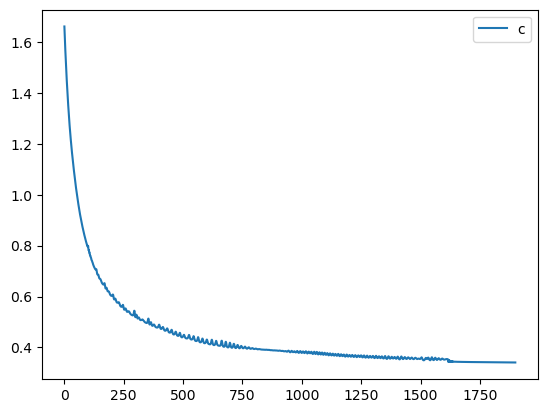

(160, 160) (160, 160) (160, 160) (160, 160) (160, 160)
(150, 150) (150, 150) (150, 150) (150, 150) (150, 150)
5
(150, 150) (150, 150) (150, 150) (150, 150) (150, 150)


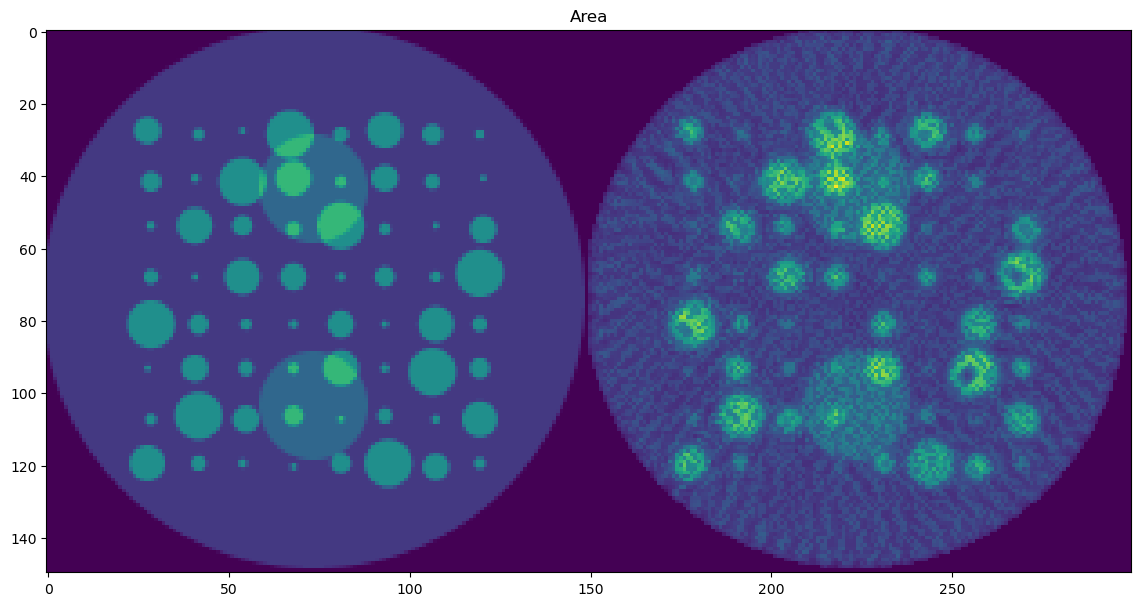

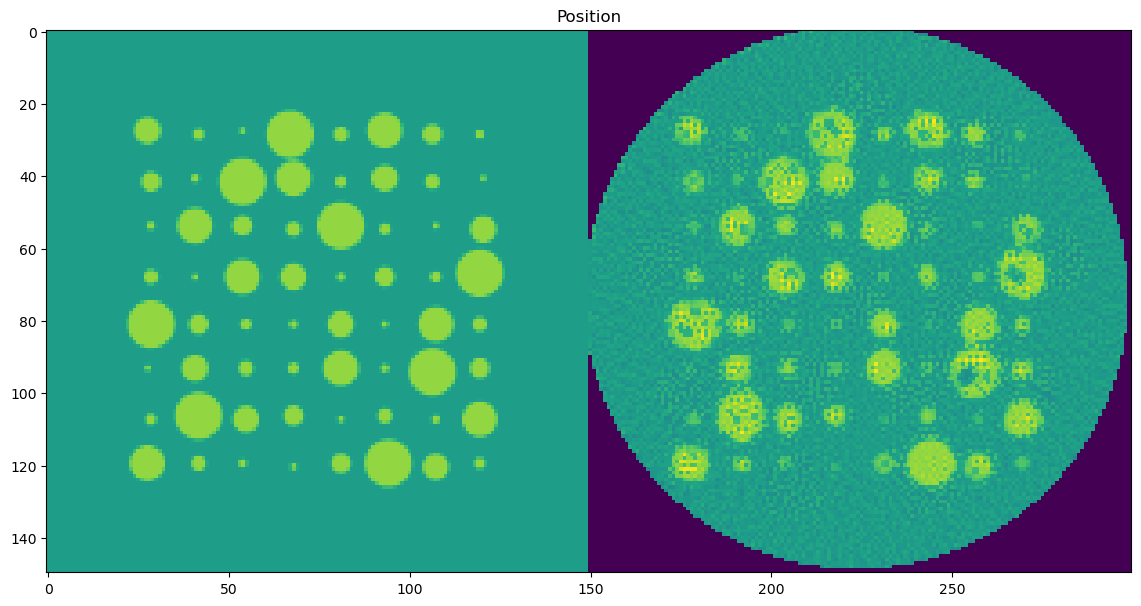

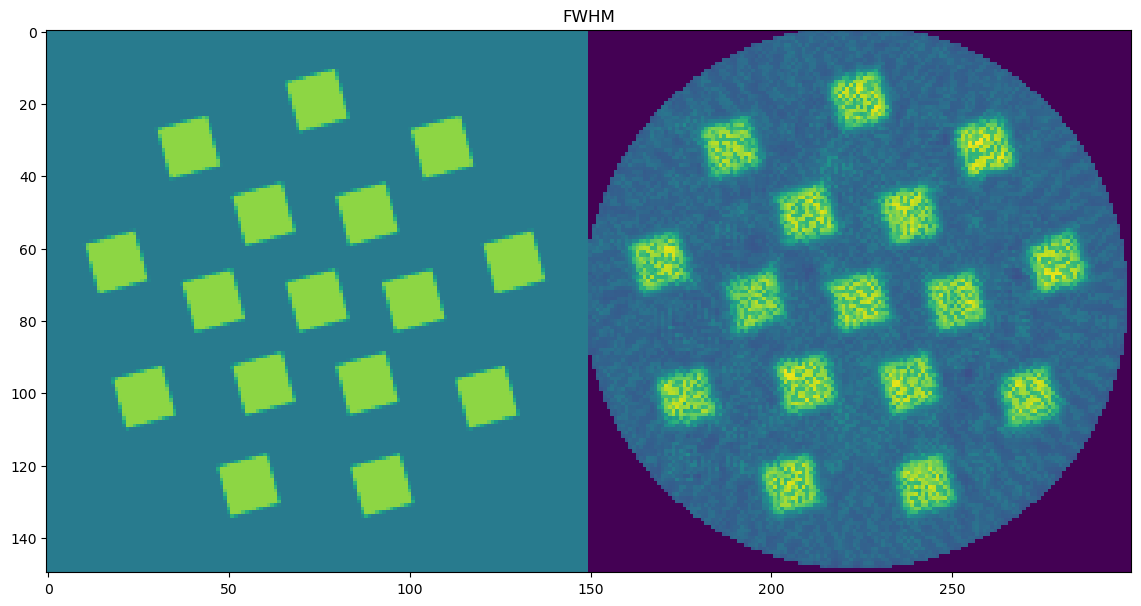

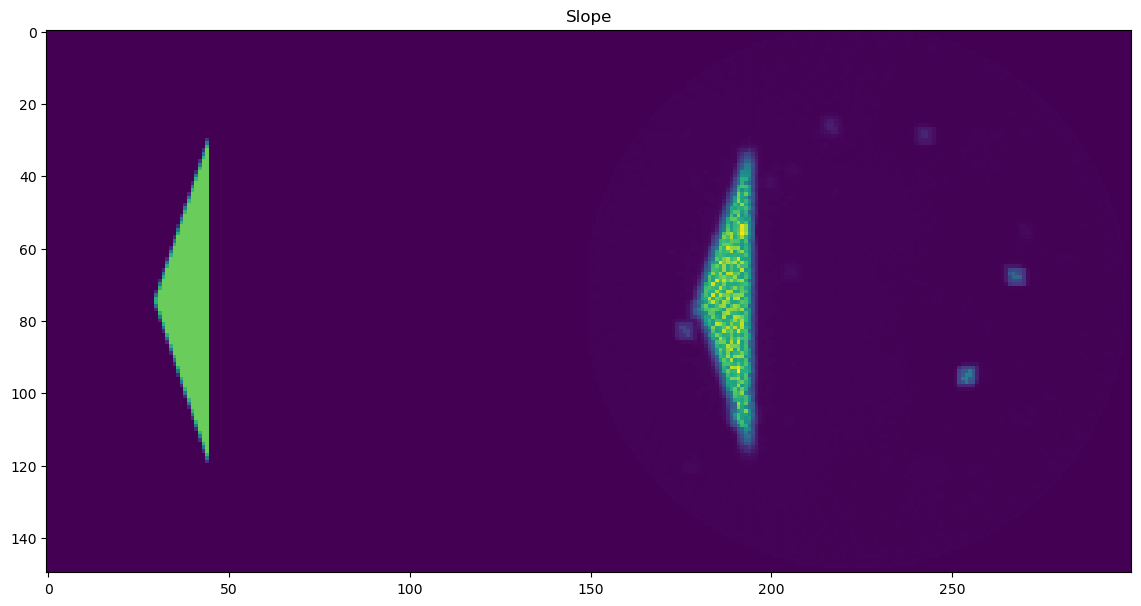

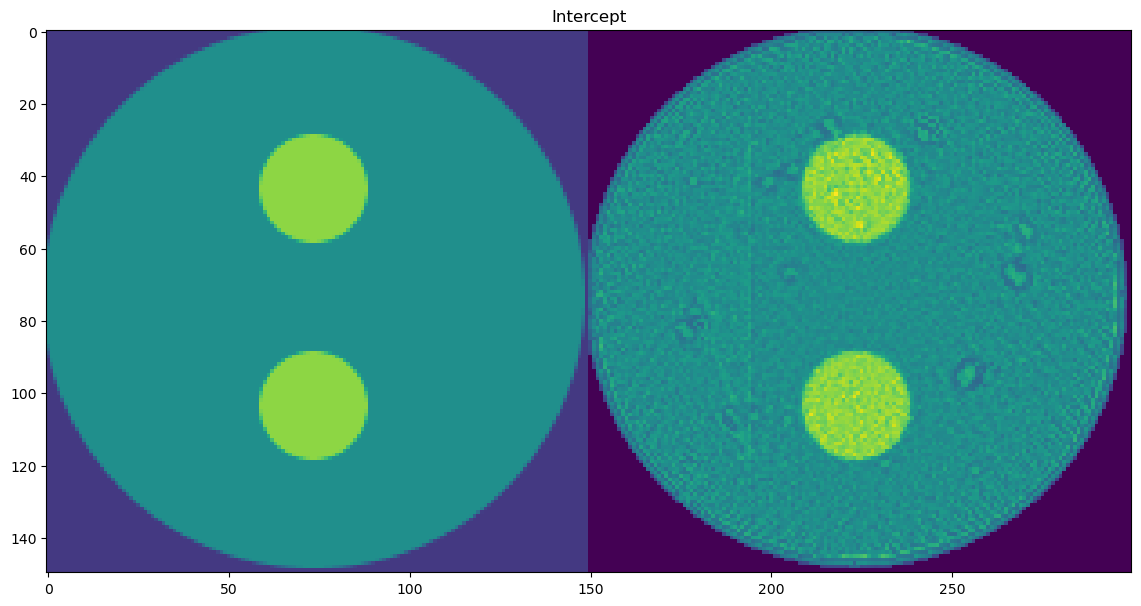

In [302]:
%matplotlib inline

plt.figure(1);plt.clf()
plt.plot(logloss[100:])
plt.legend('cnn')
plt.show()

ims = model(im_static)
filtered = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

prms_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
prms_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

print(prms_peak1_area.shape, prms_peak1_pos.shape, prms_peak1_fwhm.shape, prms_slope.shape, prms_intercept.shape)

print(peak_area.shape, peak_position.shape, peak_fwhm.shape, peak_slope.shape, peak_intercept.shape)


ofs = int((prms_peak1_area.shape[0] - peak_area.shape[0])/2)
print(ofs)

prms_peak1_area = prms_peak1_area[ofs:prms_peak1_area.shape[0]-ofs, ofs:prms_peak1_area.shape[1]-ofs]
prms_peak1_pos = prms_peak1_pos[ofs:prms_peak1_pos.shape[0]-ofs, ofs:prms_peak1_pos.shape[1]-ofs]
prms_peak1_fwhm = prms_peak1_fwhm[ofs:prms_peak1_fwhm.shape[0]-ofs, ofs:prms_peak1_fwhm.shape[1]-ofs]
prms_slope = prms_slope[ofs:prms_slope.shape[0]-ofs, ofs:prms_slope.shape[1]-ofs]
prms_intercept = prms_intercept[ofs:prms_intercept.shape[0]-ofs, ofs:prms_intercept.shape[1]-ofs]

print(prms_peak1_area.shape, prms_peak1_pos.shape, prms_peak1_fwhm.shape, prms_slope.shape, prms_intercept.shape)

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

areac = np.concatenate((peak_area, prms_peak1_area*msk), axis = 1)
posc = np.concatenate((peak_position, prms_peak1_pos*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm, prms_peak1_fwhm*msk), axis = 1)
slopec = np.concatenate((peak_slope, prms_slope*msk), axis = 1)
interceptc = np.concatenate((peak_intercept, prms_intercept*msk), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(areac)
# plt.colorbar()
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
plt.imshow(posc)
# plt.colorbar()
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
plt.imshow(fwhmc)
# plt.colorbar()
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
plt.imshow(slopec)
# plt.colorbar()
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
plt.imshow(interceptc)
# plt.colorbar()
plt.title('Intercept')
plt.show()

## 🤖 Define PeakFitCNN Model for Comparison with DLSR

To benchmark the performance of DLSR, we now set up a second approach based on **self-supervised CNN-based peak fitting** using the PeakFitCNN model. This method was previously introduced and validated in a separate notebook.

### 🧠 PeakFitCNN Overview

- The CNN receives a **4× downsampled hyperspectral input volume**.
- It predicts full-resolution parameter maps for:
  - Peak area, position, FWHM
  - Background slope and intercept
- These maps are later used to reconstruct the full volume, which can be forward-projected and compared to the original sinogram.


### ⚙️ Model Configuration

- `nch_in`: number of diffraction channels (e.g., 20)
- `nch_out`: total number of output parameter maps (5 in this case)
- `nfilts`: number of filters, chosen here as equal to input channels for simplicity
- `upscale_factor = 4`: restores full resolution from the downsampled input
- `norm_type = 'layer'`: uses layer normalization for stability
- `activation = 'Sigmoid'`: ensures output values are in [0, 1] before denormalization

The total number of trainable parameters is printed and compared to the parameter count used in the DLSR approach.


### 🔻 Input Preparation

- The FBP reconstructed volume is reshaped into a 4D tensor compatible with PyTorch
- It is then **downsampled by a factor of 4** using bilinear interpolation

This downsampled input will be used to train PeakFitCNN in a self-supervised manner, mimicking limited-resolution experimental data. The upcoming training loop will mirror that used for DLSR but applied to this deep model.

In [309]:

model_cnn = PeakFitCNN(nch_in=volp.shape[2], nch_out=nch_out, nfilts=32,  upscale_factor = 4, norm_type='layer', 
              activation='Sigmoid', padding='same', npix = volp.shape[0]//4).to(device)


nch_in = volp.shape[2]
nfilts = volp.shape[2] # 2*total_params

# Calculate the total number of parameters
model_prms = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print(f"Total number of parameters: {model_prms}")

print('Number of filters:', nfilts)
print(nch_out)

print("Conventional number of parameters:", npix*npix*total_params)

print(volp.shape[0])

ylow = np.transpose(r, (2,1,0))
ylow = torch.tensor(ylow, dtype=torch.float32, device=device)
ylow = torch.reshape(ylow, (1, ylow.shape[0], ylow.shape[1], ylow.shape[2]))
ylow = torch.transpose(ylow, 3, 2)
downsampled = F.interpolate(ylow, scale_factor=1/4, mode='bilinear', align_corners=False)
print(downsampled.shape, yobs.shape, yobs.shape[2]/4)


Total number of parameters: 2073733
Number of filters: 20
5
Conventional number of parameters: 128000
160
torch.Size([1, 20, 40, 40]) torch.Size([1, 20, 160, 160]) 40.0


## 🔁 Train PeakFitCNN Using Self-Supervised Spectral Reconstruction

In this section, we train the `PeakFitCNN` model to reconstruct peak parameters directly from the **downsampled hyperspectral input**. The training follows the same **self-supervised loss formulation** as used in DLSR, where the forward projection of the predicted volume is matched against the observed sinogram.

### 🎯 Objective

Rather than optimizing parameter maps directly, as in DLSR, we now learn a **convolutional model** that:
- Takes as input a low-resolution hyperspectral volume
- Predicts full-resolution peak parameters
- Minimizes the sinogram error via a differentiable forward model

### 🧠 Training Setup

- `param_min` and `param_max`: define valid physical ranges for each parameter
- `prf = 0.2`: soft constraint (±20%) around the local average to stabilize output
- `optimizer`: Adam with learning rate `0.001`
- `scheduler`: Reduces learning rate when validation loss plateaus
- `loss`: RMSE between generated (`s_gen`) and true (`s`) sinograms

### 🔁 Training Loop

For each epoch:
1. Forward pass through `model_cnn(downsampled)`
2. Clamp and denormalize the predicted parameter maps
3. Reconstruct the full 3D volume from the predicted parameters
4. Apply forward projection to obtain a synthetic sinogram
5. Compute reconstruction error against the observed sinogram
6. Backpropagate and update model weights

The model is trained using **end-to-end self-supervision**, without any direct labels for peak parameters.

### 📈 Output

At the end of training, the notebook reports:
- Final values for MAE, MSE, and RMSE
- Number of epochs completed
- Total training time in seconds

This completes the CNN-based reconstruction, which we will next compare visually and quantitatively against the DLSR solution.

In [ ]:
def gaussian(x, area, position, fwhm):
    """Gaussian peak shape."""
    return area * torch.exp(-(x - position)**2 / (2 * fwhm**2))
    
MAE = torch.nn.L1Loss()

### Single peak ###
param_min = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Position': torch.tensor([peak[1] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.1,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Slope': torch.zeros(1, dtype=torch.float32).to(device),
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device),
}
param_max = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 2,
    'Position': torch.tensor([peak[2] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.5,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 1,
    'Slope': torch.zeros(1, dtype=torch.float32).to(device) + 0.2,
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device) + 0.5,
}    

epochs = 50000
patience = 50 #250
min_lr = 1E-5
learning_rate = 0.001
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)
prf = 0.2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr)

start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    yc = model_cnn(downsampled)

    filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(yc)
    lower_bound = filtered * (1 - prf)
    upper_bound = filtered * (1 + prf)
    yc = torch.clamp(yc, min=lower_bound, max=upper_bound)

    y = torch.zeros((npix*npix, len(xv)), dtype=torch.float32).to(device)
    for i in range(num_peaks):
        
        area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
        position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
        fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

        area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
        position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
        fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

        area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
        position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
        fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
        
        y += gaussian(xv.unsqueeze(0), area, position, fwhm)

    slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
    intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

    slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
    intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

    slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
    intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

    y += slope * xv + intercept  
    y = torch.reshape(y, (1, npix, npix, nch))
    y = torch.transpose(y, 3, 1)
    y = torch.transpose(y, 3, 2)

    y = y * maskvol
    s_gen = forward_project_3D(y, angles, npix=yobs.shape[2], nch=yobs.shape[1], device='cuda')


    loss_mae =  MAE(s, s_gen)
    loss_mse = torch.mean((s - s_gen) ** 2)
    loss_rmse = torch.sqrt(torch.mean((s - s_gen) ** 2))
    
    loss = loss_rmse 
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
                
    logloss.append(loss.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch % int(patience*2) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)

  0%|          | 3/50000 [00:00<1:29:35,  9.30it/s]

MAE =  tensor(44.4991, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(2810.1084, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(53.0105, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  53.010456


  0%|          | 103/50000 [00:06<54:25, 15.28it/s]

MAE =  tensor(2.9959, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(25.5089, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(5.0506, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  5.050632


  0%|          | 203/50000 [00:13<54:03, 15.35it/s]  

MAE =  tensor(1.6853, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(8.6297, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(2.9376, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  2.9376414


  1%|          | 303/50000 [00:19<55:44, 14.86it/s]

MAE =  tensor(1.1820, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(3.6700, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(1.9157, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  1.9157164


  1%|          | 403/50000 [00:26<56:11, 14.71it/s]

MAE =  tensor(0.8362, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(1.7885, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(1.3373, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  1.3373489


  1%|          | 503/50000 [00:32<52:21, 15.76it/s]

MAE =  tensor(0.6090, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.9559, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.9777, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.9776781


  1%|          | 603/50000 [00:39<53:02, 15.52it/s]

MAE =  tensor(0.5155, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.6825, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.8262, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.8261593


  1%|▏         | 703/50000 [00:46<51:50, 15.85it/s]  

MAE =  tensor(0.4606, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.5408, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.7354, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.7354205


  2%|▏         | 803/50000 [00:52<54:24, 15.07it/s]

MAE =  tensor(0.3940, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.3896, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.6242, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.62415916


  2%|▏         | 903/50000 [00:59<53:20, 15.34it/s]

MAE =  tensor(0.3627, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.3270, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.5719, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.5718768


  2%|▏         | 1003/50000 [01:05<54:17, 15.04it/s]

MAE =  tensor(0.3313, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.2694, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.5190, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.5190202


  2%|▏         | 1103/50000 [01:12<53:12, 15.32it/s]

MAE =  tensor(0.3111, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.2274, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4769, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.47689337


  2%|▏         | 1203/50000 [01:18<50:42, 16.04it/s]

MAE =  tensor(0.2936, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.2066, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4545, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.45449322


  3%|▎         | 1303/50000 [01:25<50:36, 16.04it/s]

MAE =  tensor(0.2803, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1751, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4184, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.4183933


  3%|▎         | 1403/50000 [01:31<51:54, 15.60it/s]

MAE =  tensor(0.2647, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1652, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4065, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.40645012


  3%|▎         | 1503/50000 [01:38<54:05, 14.94it/s]

MAE =  tensor(0.2512, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1456, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3816, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.38160843


  3%|▎         | 1603/50000 [01:44<50:59, 15.82it/s]

MAE =  tensor(0.2398, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1316, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3628, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.36275578


  3%|▎         | 1703/50000 [01:51<52:27, 15.35it/s]

MAE =  tensor(0.2284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1186, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3443, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3443233


  4%|▎         | 1803/50000 [01:57<50:56, 15.77it/s]

MAE =  tensor(0.2337, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1089, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3300, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3300348


  4%|▍         | 1903/50000 [02:04<54:10, 14.80it/s]

MAE =  tensor(0.2098, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1037, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3220, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.32198402


  4%|▍         | 2003/50000 [02:10<50:27, 15.86it/s]

MAE =  tensor(0.2180, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3103, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.31031093


  4%|▍         | 2103/50000 [02:17<54:38, 14.61it/s]

MAE =  tensor(0.2129, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0907, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3011, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3011292


  4%|▍         | 2141/50000 [02:19<52:10, 15.29it/s]

Epoch 02138: reducing learning rate of group 0 to 5.0000e-04.


  4%|▍         | 2203/50000 [02:24<51:58, 15.33it/s]

MAE =  tensor(0.1483, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0576, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2400, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.23998103


  5%|▍         | 2303/50000 [02:30<51:01, 15.58it/s]

MAE =  tensor(0.1450, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0553, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2351, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.23508686


  5%|▍         | 2403/50000 [02:37<50:45, 15.63it/s]

MAE =  tensor(0.1414, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0523, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2288, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.2287541


  5%|▌         | 2503/50000 [02:43<49:31, 15.98it/s]

MAE =  tensor(0.1373, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0491, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2217, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.22169217


  5%|▌         | 2603/50000 [02:50<51:10, 15.44it/s]

MAE =  tensor(0.1311, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0446, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2112, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.2111931


  5%|▌         | 2657/50000 [02:53<48:39, 16.21it/s]

Epoch 02654: reducing learning rate of group 0 to 2.5000e-04.


  5%|▌         | 2703/50000 [02:56<56:24, 13.97it/s]

MAE =  tensor(0.1225, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0401, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2001, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.20014653


  6%|▌         | 2803/50000 [03:03<49:13, 15.98it/s]

MAE =  tensor(0.1175, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0378, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1943, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.1943112


  6%|▌         | 2903/50000 [03:09<52:27, 14.96it/s]

MAE =  tensor(0.1130, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0356, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1888, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.18877296


  6%|▌         | 3003/50000 [03:16<50:25, 15.54it/s]

MAE =  tensor(0.1085, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0336, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1832, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.18324654


  6%|▌         | 3103/50000 [03:22<52:55, 14.77it/s]

MAE =  tensor(0.1044, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0316, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1779, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.177903


  6%|▋         | 3203/50000 [03:29<49:53, 15.63it/s]

MAE =  tensor(0.1005, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0300, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1731, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.17309552


  7%|▋         | 3303/50000 [03:35<48:59, 15.88it/s]

MAE =  tensor(0.1006, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1719, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.17191301


  7%|▋         | 3403/50000 [03:42<49:04, 15.83it/s]

MAE =  tensor(0.0996, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0288, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1697, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.16972211


  7%|▋         | 3503/50000 [03:48<50:04, 15.48it/s]

MAE =  tensor(0.0977, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0281, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1676, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.16760084


  7%|▋         | 3603/50000 [03:55<56:27, 13.70it/s]

MAE =  tensor(0.0983, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0278, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1669, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.16686343


  7%|▋         | 3703/50000 [04:01<50:04, 15.41it/s]

MAE =  tensor(0.0955, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0274, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1656, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.1656241


  8%|▊         | 3803/50000 [04:08<51:38, 14.91it/s]

MAE =  tensor(0.0949, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0267, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1635, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.16350536


  8%|▊         | 3903/50000 [04:14<48:10, 15.95it/s]

MAE =  tensor(0.0946, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0261, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1616, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.16159905


  8%|▊         | 4003/50000 [04:21<49:21, 15.53it/s]

MAE =  tensor(0.0935, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0253, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1592, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.15917084


  8%|▊         | 4103/50000 [04:27<49:26, 15.47it/s]

MAE =  tensor(0.0922, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1569, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.15689424


  8%|▊         | 4203/50000 [04:34<47:05, 16.21it/s]

MAE =  tensor(0.0915, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0242, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1556, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.1555667


  9%|▊         | 4303/50000 [04:40<49:46, 15.30it/s]

MAE =  tensor(0.0902, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0237, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1541, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.15405439


  9%|▉         | 4403/50000 [04:47<48:03, 15.81it/s]

MAE =  tensor(0.0907, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0237, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1540, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.15402833


  9%|▉         | 4503/50000 [04:53<51:21, 14.76it/s]

MAE =  tensor(0.0873, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0234, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1531, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.15310097


  9%|▉         | 4603/50000 [05:00<48:38, 15.56it/s]

MAE =  tensor(0.0846, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0226, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1502, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.15020414


  9%|▉         | 4703/50000 [05:06<50:39, 14.90it/s]

MAE =  tensor(0.0845, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1491, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.14914167


 10%|▉         | 4803/50000 [05:13<48:07, 15.65it/s]

MAE =  tensor(0.0843, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0221, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1487, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.14866897


 10%|▉         | 4903/50000 [05:19<49:59, 15.03it/s]

MAE =  tensor(0.0839, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1494, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.14941297


 10%|▉         | 4977/50000 [05:24<46:35, 16.11it/s]

Epoch 04975: reducing learning rate of group 0 to 1.2500e-04.


 10%|█         | 5003/50000 [05:26<48:46, 15.37it/s]

MAE =  tensor(0.0744, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0193, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1391, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13909155


 10%|█         | 5103/50000 [05:32<49:10, 15.22it/s]

MAE =  tensor(0.0733, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0191, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1380, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13804807


 10%|█         | 5203/50000 [05:39<47:13, 15.81it/s]

MAE =  tensor(0.0729, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0189, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1375, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13753583


 11%|█         | 5303/50000 [05:45<53:35, 13.90it/s]

MAE =  tensor(0.0725, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0188, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1370, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13701166


 11%|█         | 5403/50000 [05:52<49:27, 15.03it/s]  

MAE =  tensor(0.0721, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0186, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1365, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13647272


 11%|█         | 5503/50000 [05:58<47:19, 15.67it/s]

MAE =  tensor(0.0717, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0185, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1359, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13591844


 11%|█         | 5603/50000 [06:05<46:38, 15.87it/s]

MAE =  tensor(0.0712, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0183, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1354, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13535455


 11%|█▏        | 5703/50000 [06:11<46:26, 15.89it/s]

MAE =  tensor(0.0708, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0182, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1348, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13478489


 12%|█▏        | 5803/50000 [06:18<48:07, 15.30it/s]

MAE =  tensor(0.0711, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0181, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1347, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.1347033


 12%|█▏        | 5903/50000 [06:24<45:35, 16.12it/s]

MAE =  tensor(0.0708, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0180, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1343, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13425641


 12%|█▏        | 5963/50000 [06:28<45:01, 16.30it/s]

Epoch 05961: reducing learning rate of group 0 to 6.2500e-05.


 12%|█▏        | 6003/50000 [06:31<48:43, 15.05it/s]

MAE =  tensor(0.0695, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0177, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1332, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13318372


 12%|█▏        | 6103/50000 [06:37<46:28, 15.74it/s]

MAE =  tensor(0.0692, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0177, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1329, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.1328792


 12%|█▏        | 6203/50000 [06:44<45:24, 16.07it/s]

MAE =  tensor(0.0690, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0176, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1326, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13257527


 13%|█▎        | 6303/50000 [06:51<51:01, 14.27it/s]

MAE =  tensor(0.0687, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0175, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1323, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13226148


 13%|█▎        | 6403/50000 [06:57<51:03, 14.23it/s]

MAE =  tensor(0.0684, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0174, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1319, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13193354


 13%|█▎        | 6503/50000 [07:04<45:45, 15.85it/s]

MAE =  tensor(0.0682, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0173, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1316, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13159491


 13%|█▎        | 6603/50000 [07:10<48:26, 14.93it/s]

MAE =  tensor(0.0679, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0172, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1312, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.1312482


 13%|█▎        | 6703/50000 [07:17<46:38, 15.47it/s]

MAE =  tensor(0.0676, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0171, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1309, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13089398


 14%|█▎        | 6803/50000 [07:23<48:17, 14.91it/s]

MAE =  tensor(0.0673, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0170, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1305, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13053358


 14%|█▍        | 6903/50000 [07:29<44:34, 16.12it/s]

MAE =  tensor(0.0670, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0169, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1302, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13016295


 14%|█▍        | 7003/50000 [07:36<47:22, 15.13it/s]

MAE =  tensor(0.0669, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0169, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1299, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12989096


 14%|█▍        | 7103/50000 [07:43<45:33, 15.69it/s]

MAE =  tensor(0.0688, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0171, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1308, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13081804


 14%|█▍        | 7203/50000 [07:49<47:39, 14.97it/s]

MAE =  tensor(0.0661, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0166, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1290, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12902479


 15%|█▍        | 7303/50000 [07:56<46:57, 15.15it/s]

MAE =  tensor(0.0670, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0167, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1293, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12933372


 15%|█▍        | 7403/50000 [08:02<45:51, 15.48it/s]

MAE =  tensor(0.0658, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0165, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1285, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12851998


 15%|█▌        | 7503/50000 [08:09<45:53, 15.43it/s]

MAE =  tensor(0.0659, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0164, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1282, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.1282396


 15%|█▌        | 7603/50000 [08:15<45:56, 15.38it/s]

MAE =  tensor(0.0650, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0163, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1276, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12757483


 15%|█▌        | 7703/50000 [08:22<45:51, 15.37it/s]

MAE =  tensor(0.0662, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0165, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1283, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12830503


 16%|█▌        | 7775/50000 [08:26<44:23, 15.86it/s]

Epoch 07772: reducing learning rate of group 0 to 3.1250e-05.


 16%|█▌        | 7803/50000 [08:28<45:38, 15.41it/s]

MAE =  tensor(0.0643, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0161, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1267, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12672633


 16%|█▌        | 7903/50000 [08:35<44:10, 15.88it/s]

MAE =  tensor(0.0641, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0160, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1265, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.126486


 16%|█▌        | 8003/50000 [08:41<43:42, 16.01it/s]

MAE =  tensor(0.0639, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0159, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1263, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12627715


 16%|█▌        | 8103/50000 [08:48<46:34, 14.99it/s]

MAE =  tensor(0.0637, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0159, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1261, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12606102


 16%|█▋        | 8203/50000 [08:54<45:13, 15.40it/s]

MAE =  tensor(0.0636, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0158, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1258, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12583333


 17%|█▋        | 8303/50000 [09:01<46:49, 14.84it/s]

MAE =  tensor(0.0634, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0158, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1256, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12558357


 17%|█▋        | 8403/50000 [09:07<43:28, 15.95it/s]

MAE =  tensor(0.0632, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0157, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1253, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12531482


 17%|█▋        | 8503/50000 [09:14<45:14, 15.29it/s]

MAE =  tensor(0.0630, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0156, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1250, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12502575


 17%|█▋        | 8603/50000 [09:20<45:09, 15.28it/s]

MAE =  tensor(0.0628, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0156, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1247, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12472249


 17%|█▋        | 8703/50000 [09:27<45:08, 15.25it/s]

MAE =  tensor(0.0626, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0155, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1244, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12441258


 18%|█▊        | 8803/50000 [09:34<43:03, 15.94it/s]

MAE =  tensor(0.0624, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0154, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1241, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12410267


 18%|█▊        | 8903/50000 [09:40<47:00, 14.57it/s]

MAE =  tensor(0.0622, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0153, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1238, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12380329


 18%|█▊        | 9003/50000 [09:47<42:56, 15.91it/s]

MAE =  tensor(0.0620, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0153, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1235, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12352128


 18%|█▊        | 9103/50000 [09:53<47:00, 14.50it/s]

MAE =  tensor(0.0620, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1233, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.1233435


 18%|█▊        | 9203/50000 [10:00<43:26, 15.65it/s]

MAE =  tensor(0.0619, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1232, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.123180136


 19%|█▊        | 9303/50000 [10:06<44:49, 15.13it/s]

MAE =  tensor(0.0613, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0150, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1226, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12258128


 19%|█▉        | 9403/50000 [10:13<42:34, 15.90it/s]

MAE =  tensor(0.0613, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0150, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1224, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12240308


 19%|█▉        | 9503/50000 [10:19<43:22, 15.56it/s]

MAE =  tensor(0.0614, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0150, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1223, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12233677


 19%|█▉        | 9603/50000 [10:26<45:00, 14.96it/s]

MAE =  tensor(0.0610, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0149, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1219, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12186845


 19%|█▉        | 9703/50000 [10:32<43:59, 15.27it/s]

MAE =  tensor(0.0607, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0148, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1216, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.121593185


 20%|█▉        | 9803/50000 [10:39<44:08, 15.18it/s]

MAE =  tensor(0.0605, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0147, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1213, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12128954


 20%|█▉        | 9903/50000 [10:45<42:58, 15.55it/s]

MAE =  tensor(0.0601, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0146, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1209, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12091939


 20%|██        | 10003/50000 [10:52<41:42, 15.98it/s]

MAE =  tensor(0.0600, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0146, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1207, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12071026


 20%|██        | 10103/50000 [10:58<41:29, 16.02it/s]

MAE =  tensor(0.0599, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0145, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1205, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12046737


 20%|██        | 10203/50000 [11:05<41:49, 15.86it/s]

MAE =  tensor(0.0599, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0145, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1203, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12032203


 21%|██        | 10303/50000 [11:11<43:17, 15.28it/s]

MAE =  tensor(0.0601, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0145, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1203, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12025439


 21%|██        | 10403/50000 [11:18<41:50, 15.78it/s]

MAE =  tensor(0.0593, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0143, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1197, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.119746566


 21%|██        | 10503/50000 [11:24<43:10, 15.24it/s]

MAE =  tensor(0.0596, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0143, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1198, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11975793


 21%|██        | 10603/50000 [11:31<44:55, 14.61it/s]

MAE =  tensor(0.0594, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0143, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1195, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11951809


 21%|██▏       | 10703/50000 [11:37<40:40, 16.10it/s]

MAE =  tensor(0.0587, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0141, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1189, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11894108


 22%|██▏       | 10803/50000 [11:44<43:33, 15.00it/s]

Epoch 10800: reducing learning rate of group 0 to 1.5625e-05.
MAE =  tensor(0.0587, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0141, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1189, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11885494


 22%|██▏       | 10903/50000 [11:50<41:56, 15.54it/s]

MAE =  tensor(0.0584, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0141, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1186, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11857584


 22%|██▏       | 11003/50000 [11:57<40:52, 15.90it/s]

MAE =  tensor(0.0583, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0140, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1185, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.118460484


 22%|██▏       | 11103/50000 [12:03<40:15, 16.10it/s]

MAE =  tensor(0.0582, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0140, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1183, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11834071


 22%|██▏       | 11203/50000 [12:10<41:54, 15.43it/s]

MAE =  tensor(0.0581, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0140, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1182, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.118215375


 23%|██▎       | 11303/50000 [12:16<43:57, 14.67it/s]

MAE =  tensor(0.0580, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0139, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1181, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11808693


 23%|██▎       | 11403/50000 [12:23<42:03, 15.29it/s]

MAE =  tensor(0.0580, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0139, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1180, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11795532


 23%|██▎       | 11503/50000 [12:30<45:18, 14.16it/s]

MAE =  tensor(0.0578, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0139, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1178, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11782054


 23%|██▎       | 11603/50000 [12:36<42:09, 15.18it/s]

MAE =  tensor(0.0577, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0138, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1177, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11768239


 23%|██▎       | 11703/50000 [12:43<39:46, 16.05it/s]

MAE =  tensor(0.0576, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0138, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1175, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.117540866


 24%|██▎       | 11803/50000 [12:49<41:16, 15.42it/s]

MAE =  tensor(0.0575, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0138, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1174, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.117395505


 24%|██▍       | 11903/50000 [12:55<40:11, 15.80it/s]

MAE =  tensor(0.0574, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0137, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1172, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11724641


 24%|██▍       | 12003/50000 [13:02<40:56, 15.47it/s]

MAE =  tensor(0.0574, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0137, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1171, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11713381


 24%|██▍       | 12103/50000 [13:08<40:29, 15.60it/s]

MAE =  tensor(0.0572, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0137, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1170, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11695879


 24%|██▍       | 12203/50000 [13:15<40:11, 15.67it/s]

MAE =  tensor(0.0579, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0138, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1173, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11733234


 25%|██▍       | 12303/50000 [13:21<42:30, 14.78it/s]

MAE =  tensor(0.0570, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0136, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1167, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11666361


 25%|██▍       | 12403/50000 [13:28<40:12, 15.58it/s]

MAE =  tensor(0.0571, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0136, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1166, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11661612


 25%|██▌       | 12503/50000 [13:35<41:04, 15.21it/s]

MAE =  tensor(0.0570, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0136, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1164, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11644307


 25%|██▌       | 12603/50000 [13:42<39:26, 15.81it/s]

MAE =  tensor(0.0566, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0135, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1162, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11620636


 25%|██▌       | 12703/50000 [13:48<38:30, 16.14it/s]

MAE =  tensor(0.0566, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0135, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1161, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11607384


 26%|██▌       | 12803/50000 [13:54<42:49, 14.48it/s]

MAE =  tensor(0.0564, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0134, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1159, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.115905896


 26%|██▌       | 12903/50000 [14:01<37:32, 16.47it/s]

MAE =  tensor(0.0563, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0134, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1158, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.115758575


 26%|██▌       | 13003/50000 [14:07<41:41, 14.79it/s]

MAE =  tensor(0.0563, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0134, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1156, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.115648136


 26%|██▌       | 13103/50000 [14:14<38:36, 15.93it/s]

MAE =  tensor(0.0561, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0133, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1155, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.115476206


 26%|██▋       | 13203/50000 [14:20<46:00, 13.33it/s]

MAE =  tensor(0.0560, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0133, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1153, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.115339525


 27%|██▋       | 13303/50000 [14:27<40:17, 15.18it/s]

MAE =  tensor(0.0559, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0133, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1152, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.115211725


 27%|██▋       | 13403/50000 [14:34<37:28, 16.28it/s]

MAE =  tensor(0.0558, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0132, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1151, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11507359


 27%|██▋       | 13503/50000 [14:40<37:59, 16.01it/s]

MAE =  tensor(0.0561, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0133, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1153, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11526006


 27%|██▋       | 13603/50000 [14:46<39:24, 15.39it/s]

MAE =  tensor(0.0557, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0132, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1149, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11486692


 27%|██▋       | 13703/50000 [14:53<40:07, 15.08it/s]

MAE =  tensor(0.0566, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0133, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1152, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11517763


 28%|██▊       | 13803/50000 [14:59<37:51, 15.93it/s]

MAE =  tensor(0.0557, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0131, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1146, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.114617504


 28%|██▊       | 13903/50000 [15:06<39:30, 15.23it/s]

MAE =  tensor(0.0553, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0131, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1144, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11436409


 28%|██▊       | 14003/50000 [15:12<39:28, 15.20it/s]

MAE =  tensor(0.0553, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0130, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1142, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.114231385


 28%|██▊       | 14102/50000 [15:19<37:25, 15.99it/s]

MAE =  tensor(0.0551, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0130, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1141, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.114064135


 28%|██▊       | 14202/50000 [15:25<39:35, 15.07it/s]

MAE =  tensor(0.0550, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0130, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1139, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11389893


 29%|██▊       | 14304/50000 [15:32<37:10, 16.00it/s]

MAE =  tensor(0.0552, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0130, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1139, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11391599


 29%|██▉       | 14404/50000 [15:38<37:23, 15.87it/s]

MAE =  tensor(0.0548, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0129, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1136, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11358317


 29%|██▉       | 14504/50000 [15:45<36:14, 16.32it/s]

MAE =  tensor(0.0548, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0129, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1134, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.113431014


 29%|██▉       | 14604/50000 [15:51<39:28, 14.94it/s]

MAE =  tensor(0.0546, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0128, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1133, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.1132624


 29%|██▉       | 14702/50000 [15:58<38:58, 15.09it/s]

MAE =  tensor(0.0549, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0128, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1133, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.113344446


 30%|██▉       | 14802/50000 [16:04<44:09, 13.29it/s]

MAE =  tensor(0.0544, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0128, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1130, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.112991534


 30%|██▉       | 14902/50000 [16:10<36:39, 15.96it/s]

MAE =  tensor(0.0544, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0127, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1128, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11282522


 30%|███       | 15002/50000 [16:17<39:58, 14.59it/s]

MAE =  tensor(0.0542, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0127, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1127, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11265801


 30%|███       | 15104/50000 [16:23<34:38, 16.79it/s]

MAE =  tensor(0.0546, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0127, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1128, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.112836555


 30%|███       | 15203/50000 [16:30<38:06, 15.22it/s]

MAE =  tensor(0.0540, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0126, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1124, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11236542


 31%|███       | 15303/50000 [16:36<37:22, 15.47it/s]

MAE =  tensor(0.0539, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0126, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1122, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.1122214


 31%|███       | 15402/50000 [16:43<38:01, 15.17it/s]

MAE =  tensor(0.0542, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0126, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1123, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11225506


 31%|███       | 15504/50000 [16:49<36:44, 15.65it/s]

MAE =  tensor(0.0537, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0125, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1119, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11190898


 31%|███       | 15604/50000 [16:56<36:56, 15.52it/s]

MAE =  tensor(0.0549, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0126, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1124, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11243467


 31%|███▏      | 15702/50000 [17:02<38:06, 15.00it/s]

MAE =  tensor(0.0535, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0124, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1116, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.111553155


 32%|███▏      | 15804/50000 [17:09<37:30, 15.19it/s]

MAE =  tensor(0.0540, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0125, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1117, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.111748956


 32%|███▏      | 15904/50000 [17:15<34:30, 16.47it/s]

MAE =  tensor(0.0533, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0124, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1112, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11115932


 32%|███▏      | 16004/50000 [17:21<35:09, 16.11it/s]

MAE =  tensor(0.0532, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0123, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1110, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11095924


 32%|███▏      | 16104/50000 [17:28<37:01, 15.26it/s]

MAE =  tensor(0.0536, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0123, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1110, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11100315


 32%|███▏      | 16204/50000 [17:35<36:42, 15.34it/s]

MAE =  tensor(0.0529, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0122, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1106, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11057009


 33%|███▎      | 16304/50000 [17:41<36:38, 15.32it/s]

MAE =  tensor(0.0528, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0122, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1104, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.110376745


 33%|███▎      | 16404/50000 [17:47<34:45, 16.11it/s]

MAE =  tensor(0.0529, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0122, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1103, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11026013


 33%|███▎      | 16504/50000 [17:54<36:48, 15.17it/s]

MAE =  tensor(0.0526, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0121, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1100, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11001522


 33%|███▎      | 16604/50000 [18:00<36:34, 15.22it/s]

MAE =  tensor(0.0525, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0121, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1098, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10984704


 33%|███▎      | 16704/50000 [18:07<34:04, 16.29it/s]

MAE =  tensor(0.0528, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0121, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1098, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.109823585


 34%|███▎      | 16802/50000 [18:13<39:22, 14.05it/s]

MAE =  tensor(0.0524, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0120, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1095, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10954277


 34%|███▍      | 16904/50000 [18:20<35:40, 15.46it/s]

MAE =  tensor(0.0523, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0120, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1094, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10935055


 34%|███▍      | 17004/50000 [18:26<36:57, 14.88it/s]

MAE =  tensor(0.0522, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0119, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1092, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10920344


 34%|███▍      | 17104/50000 [18:33<34:37, 15.83it/s]

MAE =  tensor(0.0522, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0119, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1091, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10906635


 34%|███▍      | 17202/50000 [18:39<35:25, 15.43it/s]

MAE =  tensor(0.0520, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0119, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1089, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10891261


 35%|███▍      | 17302/50000 [18:46<35:11, 15.49it/s]

MAE =  tensor(0.0520, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0118, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1087, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10869235


 35%|███▍      | 17403/50000 [18:52<35:24, 15.34it/s]

MAE =  tensor(0.0519, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0118, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1086, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10856395


 35%|███▌      | 17503/50000 [18:59<34:28, 15.71it/s]

MAE =  tensor(0.0519, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0118, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1086, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10855546


 35%|███▌      | 17603/50000 [19:05<35:59, 15.00it/s]

MAE =  tensor(0.0518, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0118, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1084, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.108409815


 35%|███▌      | 17703/50000 [19:12<34:57, 15.40it/s]

MAE =  tensor(0.0518, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0117, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1083, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10829971


 36%|███▌      | 17803/50000 [19:18<35:01, 15.32it/s]

MAE =  tensor(0.0516, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0117, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1081, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10811513


 36%|███▌      | 17903/50000 [19:24<35:07, 15.23it/s]

MAE =  tensor(0.0516, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0117, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1080, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10803128


 36%|███▌      | 18003/50000 [19:31<34:19, 15.53it/s]

MAE =  tensor(0.0514, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0116, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1079, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10790602


 36%|███▌      | 18102/50000 [19:37<35:36, 14.93it/s]

MAE =  tensor(0.0513, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0116, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1078, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10780566


 36%|███▋      | 18204/50000 [19:44<34:17, 15.45it/s]

MAE =  tensor(0.0516, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0116, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1079, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.107862025


 37%|███▋      | 18302/50000 [19:50<32:09, 16.43it/s]

MAE =  tensor(0.0512, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0116, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1076, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10760821


 37%|███▋      | 18404/50000 [19:57<34:09, 15.42it/s]

MAE =  tensor(0.0518, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0117, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1080, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10799359


 37%|███▋      | 18504/50000 [20:03<33:07, 15.85it/s]

MAE =  tensor(0.0511, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0115, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1074, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10741263


 37%|███▋      | 18603/50000 [20:10<33:22, 15.68it/s]

MAE =  tensor(0.0510, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0115, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1073, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.107317485


 37%|███▋      | 18704/50000 [20:16<31:53, 16.35it/s]

MAE =  tensor(0.0514, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0115, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1074, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.107400715


 38%|███▊      | 18804/50000 [20:23<35:57, 14.46it/s]

MAE =  tensor(0.0509, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0115, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1071, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10713852


 38%|███▊      | 18904/50000 [20:29<32:49, 15.79it/s]

MAE =  tensor(0.0511, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0115, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1071, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10714623


 38%|███▊      | 19004/50000 [20:36<33:48, 15.28it/s]

MAE =  tensor(0.0508, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0114, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1070, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10695569


 38%|███▊      | 19102/50000 [20:42<31:41, 16.25it/s]

MAE =  tensor(0.0526, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0116, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1078, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10780474


 38%|███▊      | 19204/50000 [20:49<32:19, 15.88it/s]

MAE =  tensor(0.0507, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0114, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1067, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.106733814


 39%|███▊      | 19304/50000 [20:55<31:38, 16.17it/s]

MAE =  tensor(0.0507, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0114, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1066, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10664058


 39%|███▉      | 19404/50000 [21:02<33:53, 15.04it/s]

MAE =  tensor(0.0505, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0113, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1065, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.106496364


 39%|███▉      | 19504/50000 [21:08<34:00, 14.95it/s]

MAE =  tensor(0.0507, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0113, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1065, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.106463216


 39%|███▉      | 19602/50000 [21:15<33:18, 15.21it/s]

MAE =  tensor(0.0504, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0113, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1063, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.106265455


 39%|███▉      | 19704/50000 [21:21<34:05, 14.81it/s]

MAE =  tensor(0.0503, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0113, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1062, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.106153734


 40%|███▉      | 19802/50000 [21:28<34:01, 14.79it/s]

MAE =  tensor(0.0503, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0112, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1060, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10603327


 40%|███▉      | 19902/50000 [21:34<34:20, 14.61it/s]

MAE =  tensor(0.0503, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0112, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1060, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10595126


 40%|████      | 20002/50000 [21:40<31:20, 15.95it/s]

MAE =  tensor(0.0501, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0112, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1058, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10576436


 40%|████      | 20104/50000 [21:47<32:07, 15.51it/s]

MAE =  tensor(0.0502, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0112, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1057, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.105706744


 40%|████      | 20202/50000 [21:53<30:53, 16.08it/s]

MAE =  tensor(0.0501, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0111, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1056, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.105555005


 41%|████      | 20304/50000 [22:00<33:28, 14.79it/s]

MAE =  tensor(0.0499, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0111, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1053, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10526811


 41%|████      | 20404/50000 [22:06<33:58, 14.52it/s]

MAE =  tensor(0.0498, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0110, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1051, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10508346


 41%|████      | 20504/50000 [22:13<31:06, 15.80it/s]

MAE =  tensor(0.0497, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0110, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1049, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10491126


 41%|████      | 20604/50000 [22:19<32:14, 15.19it/s]

MAE =  tensor(0.0496, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0110, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1047, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10473836


 41%|████▏     | 20704/50000 [22:25<30:31, 16.00it/s]

MAE =  tensor(0.0497, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0110, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1047, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10471407


 42%|████▏     | 20802/50000 [22:32<35:58, 13.53it/s]

MAE =  tensor(0.0495, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0109, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1044, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.104426935


 42%|████▏     | 20904/50000 [22:38<30:33, 15.87it/s]

MAE =  tensor(0.0498, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0109, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1045, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10445306


 42%|████▏     | 21002/50000 [22:45<30:55, 15.63it/s]

MAE =  tensor(0.0495, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0109, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1042, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10417153


 42%|████▏     | 21104/50000 [22:51<30:15, 15.92it/s]

MAE =  tensor(0.0493, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0108, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1040, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10401733


 42%|████▏     | 21202/50000 [22:58<33:07, 14.49it/s]

MAE =  tensor(0.0492, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0108, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1039, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10386948


 43%|████▎     | 21304/50000 [23:05<29:34, 16.17it/s]

MAE =  tensor(0.0501, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0109, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1042, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.104164846


 43%|████▎     | 21404/50000 [23:11<28:19, 16.83it/s]

MAE =  tensor(0.0492, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0108, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1037, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.103700124


 43%|████▎     | 21502/50000 [23:17<33:25, 14.21it/s]

MAE =  tensor(0.0495, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0107, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1036, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10363597


 43%|████▎     | 21603/50000 [23:23<28:11, 16.78it/s]

MAE =  tensor(0.0490, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0107, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1033, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.103344716


 43%|████▎     | 21703/50000 [23:30<35:31, 13.28it/s]

MAE =  tensor(0.0489, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0106, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1032, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10319713


 44%|████▎     | 21803/50000 [23:37<30:22, 15.47it/s]

MAE =  tensor(0.0494, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0107, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1035, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10348639


 44%|████▍     | 21903/50000 [23:43<34:24, 13.61it/s]

MAE =  tensor(0.0489, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0106, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1029, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.102948576


 44%|████▍     | 22003/50000 [23:50<29:39, 15.73it/s]

MAE =  tensor(0.0488, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0106, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1028, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10283408


 44%|████▍     | 22103/50000 [23:56<34:47, 13.36it/s]

MAE =  tensor(0.0496, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0107, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1032, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10322588


 44%|████▍     | 22203/50000 [24:03<31:23, 14.76it/s]

MAE =  tensor(0.0490, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0106, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1028, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10281661


 45%|████▍     | 22303/50000 [24:09<28:19, 16.30it/s]

MAE =  tensor(0.0486, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0105, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1025, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.102462895


 45%|████▍     | 22403/50000 [24:16<28:16, 16.27it/s]

MAE =  tensor(0.0486, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0105, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1024, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10236789


 45%|████▌     | 22503/50000 [24:22<28:30, 16.08it/s]

MAE =  tensor(0.0486, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0105, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1022, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10224842


 45%|████▌     | 22603/50000 [24:28<30:33, 14.94it/s]

MAE =  tensor(0.0493, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0105, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1025, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10251822


 45%|████▌     | 22703/50000 [24:35<29:45, 15.29it/s]

MAE =  tensor(0.0484, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0104, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1021, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10206537


 46%|████▌     | 22803/50000 [24:41<30:19, 14.95it/s]

MAE =  tensor(0.0483, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0104, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1019, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.101919115


 46%|████▌     | 22862/50000 [24:45<29:23, 15.39it/s]

Epoch 22863: reducing learning rate of group 0 to 1.0000e-05.
Minimum learning rate reached, stopping the optimization
22862
22862 tensor(0.0484, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0104, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.1019, device='cuda:0', grad_fn=<SqrtBackward0>) 0.10190353
1485.8935465812683


## 🧪 Visual Comparison of CNN vs. DLSR vs. Ground Truth

After completing training for the CNN-based reconstruction, we extract the final parameter maps and visually compare them side-by-side with:
- The **ground truth maps** from the synthetic phantom
- The maps reconstructed using **DLSR**
- The maps predicted by **PeakFitCNN**

### 📉 Loss Curve

We begin by plotting the RMSE loss (`logloss`) from the CNN training to verify convergence and performance.

### 🗺️ Extract CNN Parameter Maps

We:
- Perform a final forward pass through the trained `model_cnn`
- Apply local smoothing and soft clamping
- Denormalize all five peak parameters to physical units

Cropped padding is removed using `ofs`, and a mask (`msk`) is applied to ignore low-signal/background areas in the comparison.

### 🧭 Visual Layout

For each parameter (Area, Position, FWHM, Slope, Intercept), we concatenate the masked maps:
- **Left**: Ground truth
- **Middle**: DLSR (parameter-map-only PrmCNN2D)
- **Right**: PeakFitCNN (from downsampled input)

This layout allows qualitative assessment of:
- **Accuracy**: closeness to ground truth
- **Smoothness**: spatial continuity
- **Noise suppression**: denoising capability under angular undersampling

### 🖼️ Display Results

All parameter maps are shown using the `'jet'` colormap for enhanced contrast. The results suggest that both DLSR and CNN-based approaches recover the key spatial patterns well, with CNN exhibiting better smoothness in some cases — particularly under undersampled conditions.

In the next step, a quantitative comparison (e.g. RMSE or SSIM) can further validate these observations.

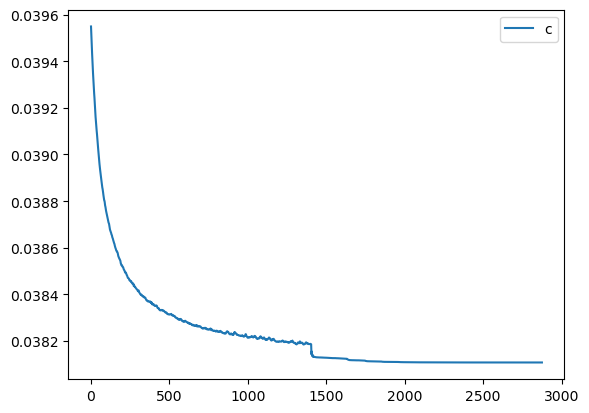

5


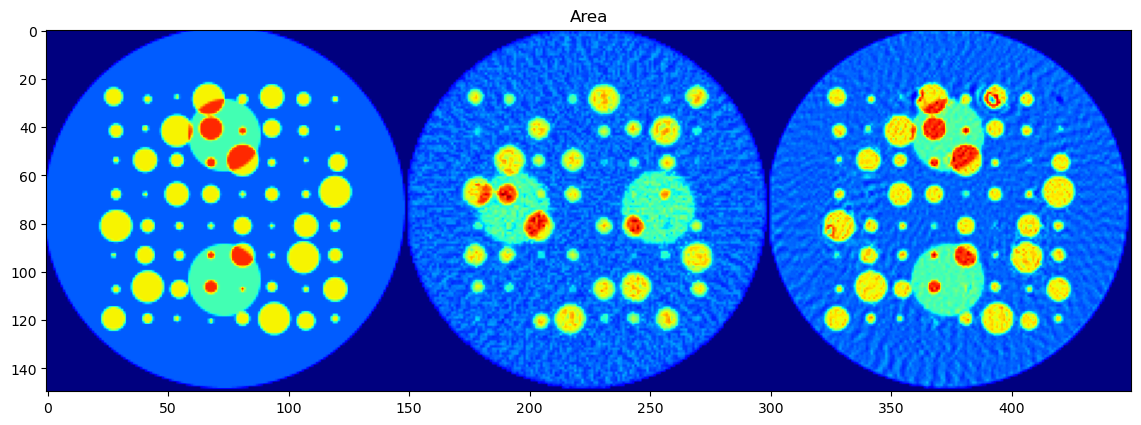

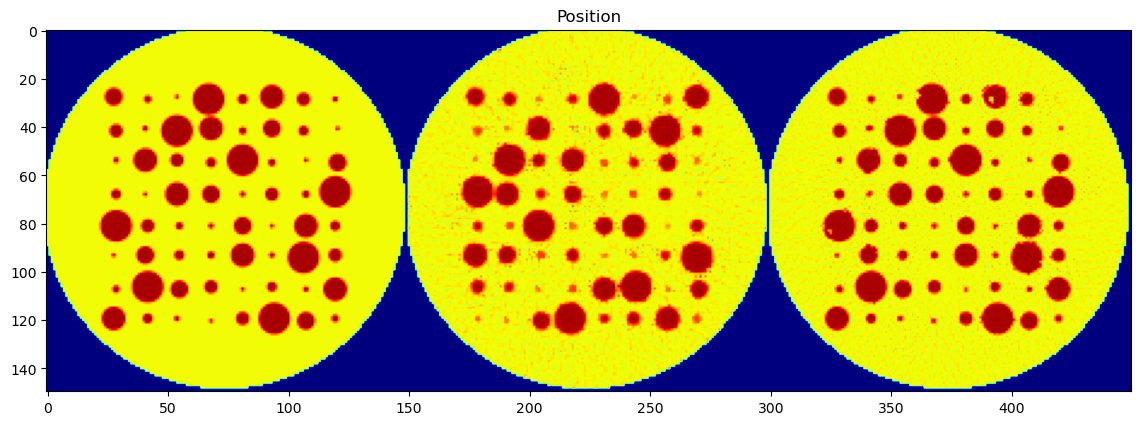

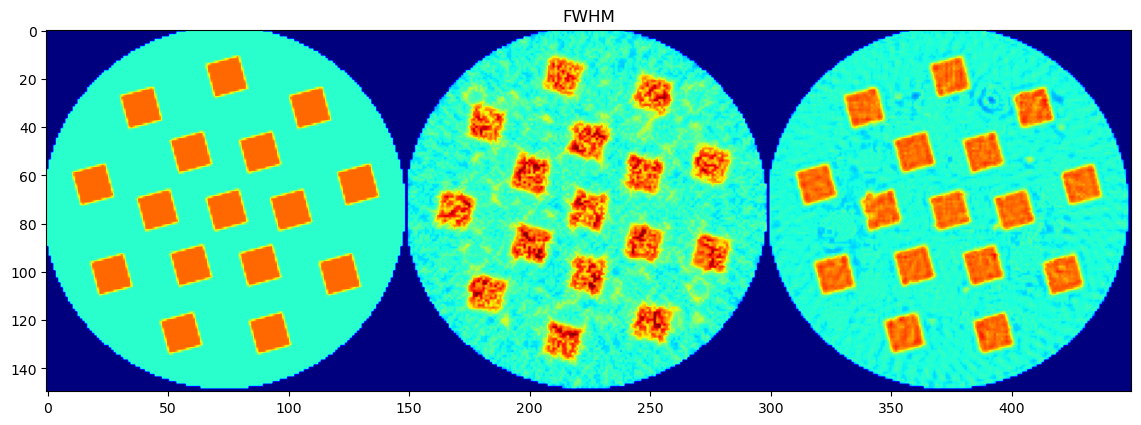

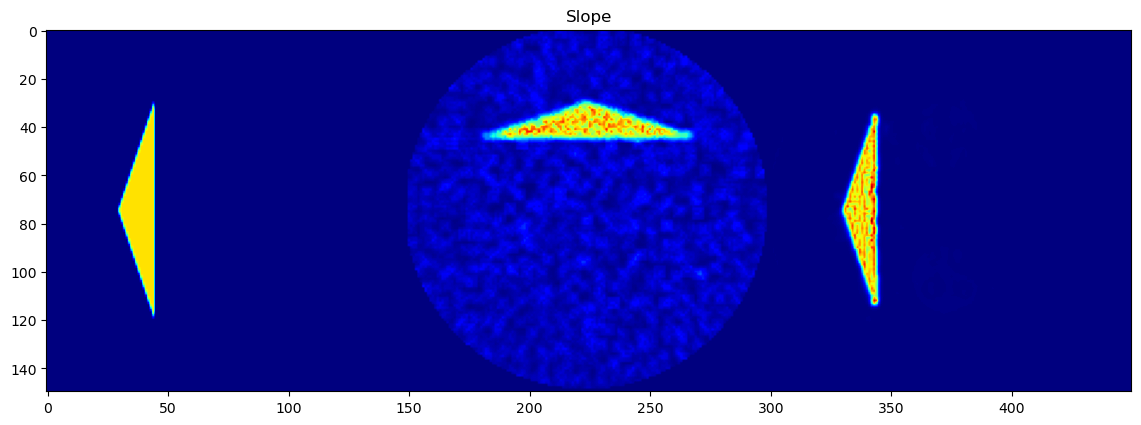

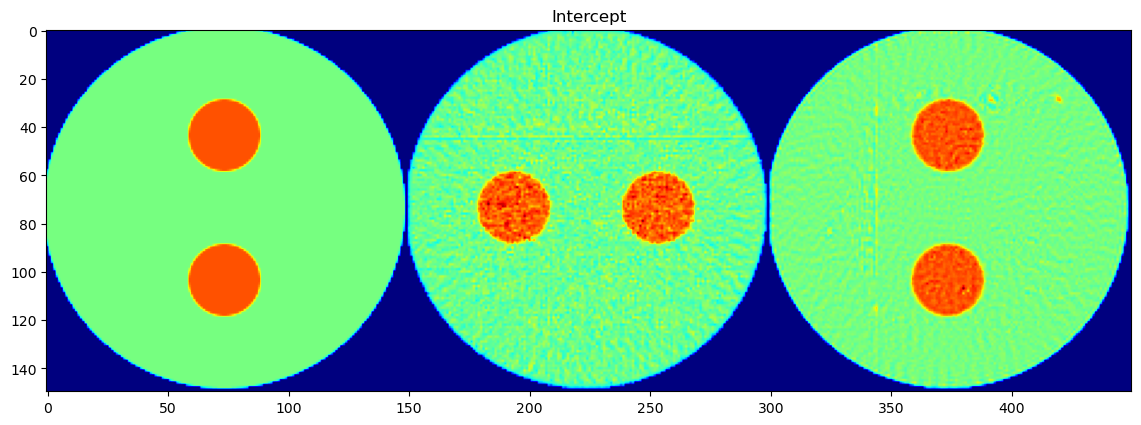

In [316]:
%matplotlib inline

plt.figure(1);plt.clf()
plt.plot(logloss[100:])
plt.legend('cnn')
plt.show()

ims = model_cnn(downsampled)

filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

cnn_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
cnn_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

ofs = int((cnn_peak1_area.shape[0] - peak_area.shape[0])/2)
print(ofs)

cnn_peak1_area = cnn_peak1_area[ofs:cnn_peak1_area.shape[0]-ofs, ofs:cnn_peak1_area.shape[1]-ofs]
cnn_peak1_pos = cnn_peak1_pos[ofs:cnn_peak1_pos.shape[0]-ofs, ofs:cnn_peak1_pos.shape[1]-ofs]
cnn_peak1_fwhm = cnn_peak1_fwhm[ofs:cnn_peak1_fwhm.shape[0]-ofs, ofs:cnn_peak1_fwhm.shape[1]-ofs]
cnn_slope = cnn_slope[ofs:cnn_slope.shape[0]-ofs, ofs:cnn_slope.shape[1]-ofs]
cnn_intercept = cnn_intercept[ofs:cnn_intercept.shape[0]-ofs, ofs:cnn_intercept.shape[1]-ofs]

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

areac = np.concatenate((peak_area*msk, prms_peak1_area*msk, cnn_peak1_area*msk), axis = 1)
posc = np.concatenate((peak_position*msk, prms_peak1_pos*msk, cnn_peak1_pos*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm*msk, prms_peak1_fwhm*msk, cnn_peak1_fwhm*msk), axis = 1)
slopec = np.concatenate((peak_slope*msk, prms_slope*msk, cnn_slope*msk), axis = 1)
interceptc = np.concatenate((peak_intercept*msk, prms_intercept*msk, cnn_intercept*msk), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(areac, cmap = 'jet')
# plt.colorbar()
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
plt.imshow(posc, cmap = 'jet')
# plt.colorbar()
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
plt.imshow(fwhmc, cmap = 'jet')
# plt.colorbar()
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
plt.imshow(slopec, cmap = 'jet')
# plt.colorbar()
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
plt.imshow(interceptc, cmap = 'jet')
# plt.colorbar()
plt.title('Intercept')
plt.show()


## 🔍 Patch-Based Sampling on FBP-Reconstructed Volume

This section defines a patch sampling strategy for the **FBP + peak fitting** pipeline, enabling efficient evaluation or training using the reconstructed volume `r` as input.

### 🎯 Purpose

Patch-based sampling allows us to:
- Randomly probe local regions of the FBP volume
- Enable fair comparison with CNN and DLSR methods that were also trained on patches
- Optionally fit peaks or extract local statistics from each patch

### 🧱 Workflow

1. **Volume and Mask Padding**:
   - Padding is added around the spatial edges of both the FBP volume (`r`) and the binary mask.
   - This ensures patches sampled near the boundary are still valid.

2. **Mask Generation**:
   - A binary mask is generated by summing the FBP volume along the spectral axis.
   - Voxels with non-zero values are marked as valid for sampling.

3. **Patch Index Filtering**:
   - Using `filter_patch_indices()`, we identify valid patch locations that overlap with signal.
   - The number of patches per iteration and total number of required iterations to probe the entire image are computed.

4. **Coverage Diagnostic**:
   - A counter tracks how often each voxel is sampled.
   - This is visualized to ensure spatially uniform coverage across the volume.

### 📈 Output

The code prints:
- Volume and mask shapes after padding
- Estimated patch coverage per epoch
- Number of required iterations to probe the full image
- Number of valid patches available
- Visualization of the sampling density

This setup prepares the FBP data for further analysis — for example, comparing peak fitting accuracy or robustness under noisy or undersampled conditions.

(224, 224, 20) (160, 160, 20) (224, 224)


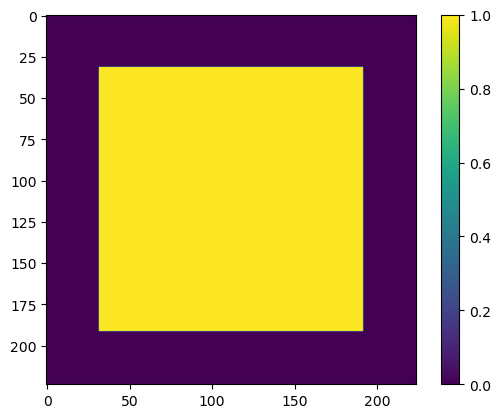

Percentage of pixels probed during one epoch: 64.0
Number of iterations required to probe full image: 2
The number of patches is  25
The number of iterations (batches) required to probe the whole image is  1
tensor(1.)


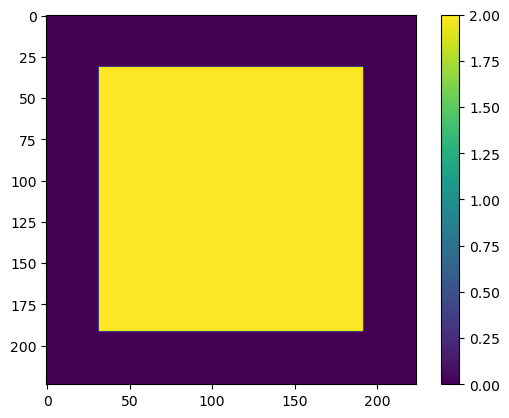

(224, 224, 20) (160, 160, 20) (224, 224)


In [317]:
%matplotlib inline

num_iterations = 100
distribution_type = 'uniform'
std_dev = int(r.shape[0] / 1)
device = 'cuda'
patch_size = 32
num_patches = 16
num_patches_total = 16

mask = np.copy(np.sum(r,axis=2))
mask[mask>0] = 1
mask = np.concatenate((np.zeros((patch_size, mask.shape[1]), dtype='float32'), mask, np.zeros((patch_size, mask.shape[1]), dtype='float32')), axis = 0)
mask = np.concatenate((np.zeros((mask.shape[0], patch_size), dtype='float32'), mask, np.zeros((mask.shape[0], patch_size), dtype='float32')), axis = 1)

volp = np.copy(r)
volp = np.concatenate((np.zeros((patch_size, volp.shape[1], volp.shape[2]), dtype='float32'), volp, np.zeros((patch_size, volp.shape[1], volp.shape[2]), dtype='float32')), axis = 0)
volp = np.concatenate((np.zeros((volp.shape[0], patch_size, volp.shape[2]), dtype='float32'), volp, np.zeros((volp.shape[0], patch_size, volp.shape[2]), dtype='float32')), axis = 1)
rows, cols = volp.shape[0], volp.shape[1]  # Size of the matrix
print(volp.shape, r.shape, mask.shape)

plt.figure(1);plt.clf()
plt.imshow(mask)
plt.colorbar()
plt.show()

npix = np.sum(mask)
pcr_probed = 100* (patch_size*patch_size*num_patches)/npix
print(f"Percentage of pixels probed during one epoch: {pcr_probed}")
niters_required = int(np.ceil(100/pcr_probed))
print(f"Number of iterations required to probe full image: {niters_required}")

mask_t = torch.tensor(mask, dtype=torch.bool, device=device)

indices = filter_patch_indices(torch.tensor(mask), patch_size)
print('The number of patches is ', len(indices))
print('The number of iterations (batches) required to probe the whole image is ', int(len(indices)/num_patches) )


counter = initialize_counter(rows, cols)
patch_dimensions = (patch_size, patch_size)
update_counter(counter, indices, patch_dimensions)

print(counter.max())

counter = counter.numpy()

plt.figure(2);plt.clf()
# plt.imshow(counter * mask )
plt.imshow(counter + mask)
# plt.clim(0,1)
plt.colorbar()
plt.show()

print(volp.shape, vol.shape, mask.shape)


## 🔁 Train Parameter Maps on FBP-Reconstructed Volume (FBP + Peak Fitting)

This section trains parameter maps directly on the **FBP-reconstructed volume** using the same architecture (`PrmCNN2D`) and training strategy as in the DLSR case. The difference here is that the input data is a **reconstructed volume** (`r`) rather than raw sinogram data.

### 🎯 Purpose

This pipeline simulates the conventional XRD-CT workflow:
1. Reconstruct the 3D volume using FBP
2. Fit diffraction patterns voxel-by-voxel to extract physical parameters (area, position, FWHM, etc.)

By training `PrmCNN2D` to minimize reconstruction error, we obtain spatially smooth parameter maps from the FBP output.

### ⚙️ Training Configuration

- Input: `im_static`, a single-channel static image computed from the FBP volume
- Patch-based training ensures efficiency and robustness
- `prf = 0.2`: enforces stability by soft-clamping parameter predictions
- Training loss is RMSE between the observed FBP voxel spectra and those reconstructed from the fitted parameters

### 🔁 Training Loop

Each epoch consists of:
1. Predicting parameter maps (`yc`)
2. Clamping predictions and extracting patches
3. Constructing synthetic spectra from peak + background parameters
4. Comparing synthetic spectra with the ground truth patches (`yobs`)
5. Computing RMSE and updating the model

### 📈 Output

The model prints:
- MAE, MSE, RMSE at intermediate epochs
- Accumulated loss over iterations
- Total training time and number of completed epochs

This completes the **FBP + peak fitting pipeline**, enabling direct comparison with DLSR and CNN-based methods in the final evaluation section.

In [ ]:

npix_x = volp.shape[0]
npix_y = volp.shape[1]
xv = torch.tensor(x, dtype=torch.float32, device='cuda')

### Single peak
peak_definitions = [(1, 1.0, 4.0)]

num_peaks = len(peak_definitions)
num_params_per_peak = 3  # Area, Position, FWHM
background_params = 2  # Slope, Intercept
total_params = num_peaks * num_params_per_peak + background_params

npix = volp.shape[0]
nch_in = total_params
nch_out = total_params
nfilts = 2*total_params # 2*total_params is pretty good when using norm layer
norm_type='layer'
activation='Sigmoid'
downsampling = 8
device = 'cuda'

model = PrmCNN2D(npix, nch_in=nch_in, nch_out=nch_out, nfilts=nfilts, nlayers=1, norm_type='None', prms_layer=True, cnn_layer=False, tensor_vals = 'zeros').to(device)
model_prms = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {model_prms}")
print("Conventional number of parameters:", npix*npix*total_params)

def gaussian(x, area, position, fwhm):
    """Gaussian peak shape."""
    return area * torch.exp(-(x - position)**2 / (2 * fwhm**2))
    
MAE = torch.nn.L1Loss()

### Single peak ###
param_min = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Position': torch.tensor([peak[1] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.1,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Slope': torch.zeros(1, dtype=torch.float32).to(device),
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device),
}
param_max = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 2,
    'Position': torch.tensor([peak[2] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.5,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 1,
    'Slope': torch.zeros(1, dtype=torch.float32).to(device) + 0.2,
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device) + 0.5,
}    

nch = volp.shape[2]
learning_rate = 0.001
epochs = 10000
min_lr = 1E-5

im_static = np.sum(volp, axis=2)
im_static = im_static/np.max(im_static)
im_static = np.reshape(im_static, (1, 1, volp.shape[1], volp.shape[1]))
im_static = torch.tensor(im_static, dtype=torch.float32, device=device)

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)

epochs = 50000
patience = 100 #250
min_lr = 1E-5
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
prf = 0.2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr)

num_patches = 16
new_indices = np.array(indices)
total_indices = len(indices)
num_batches = (total_indices + num_patches - 1) // num_patches
print(num_batches)

start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    for batch_index in range(num_batches):
        start_index = batch_index * num_patches
        end_index = min(start_index + num_patches, total_indices)
        batch_indices = new_indices[start_index:end_index]

        yc = model(im_static)
        filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(yc)

        lower_bound = filtered * (1 - prf)
        upper_bound = filtered * (1 + prf)

        yc = torch.clamp(yc, min=lower_bound, max=upper_bound)

        yc = calc_patches_indices(batch_indices, yc, patch_size, use_middle=False)

        y = torch.zeros((patch_size*patch_size*len(batch_indices), len(xv)), dtype=torch.float32).to(device)
        
        for i in range(num_peaks):
            area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
            position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
            fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

            area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
            position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
            fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

            area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
            position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
            fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
            
            y += gaussian(xv.unsqueeze(0), area, position, fwhm)
        
        slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
        intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

        slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
        intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

        slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
        intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

        y += slope * xv + intercept  

        patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False)  
                
        patches = torch.reshape(patches, (patches.shape[0],patches.shape[1],patches.shape[2]*patches.shape[3]))
        patches = torch.transpose(patches, 1, 2)
        patches = torch.transpose(patches, 1, 0)
        y = torch.reshape(y, (patches.shape[0], patches.shape[1], nch))

        loss_mae =  MAE(patches, y)
        loss_mse = torch.mean((patches - y) ** 2)
        loss_rmse = torch.sqrt(torch.mean((patches - y) ** 2))
        
        loss_acc = loss_acc + loss_rmse

        loss = loss_rmse 
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    loss_acc = loss_acc/num_batches
                
    logloss.append(loss_acc.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch %  (int(patience/2)) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)

Total number of parameters: 250880
Conventional number of parameters: 250880
2


  0%|          | 3/50000 [00:00<28:00, 29.75it/s]

MAE =  tensor(0.4803, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.3380, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.5814, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.5832632


  0%|          | 59/50000 [00:00<12:50, 64.78it/s]

MAE =  tensor(0.0332, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0430, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04248252


  0%|          | 109/50000 [00:01<12:43, 65.34it/s]

MAE =  tensor(0.0309, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0407, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04015833


  0%|          | 161/50000 [00:02<12:11, 68.15it/s]

MAE =  tensor(0.0304, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0401, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03961435


  0%|          | 210/50000 [00:03<12:33, 66.10it/s]

MAE =  tensor(0.0301, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0398, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03937123


  1%|          | 259/50000 [00:03<12:28, 66.46it/s]

MAE =  tensor(0.0300, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0397, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039243616


  1%|          | 310/50000 [00:04<12:26, 66.57it/s]

MAE =  tensor(0.0299, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0396, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039153587


  1%|          | 362/50000 [00:05<11:49, 70.00it/s]

MAE =  tensor(0.0298, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0396, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03909548


  1%|          | 412/50000 [00:06<11:58, 68.97it/s]

MAE =  tensor(0.0298, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0395, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039055906


  1%|          | 464/50000 [00:07<12:06, 68.20it/s]

MAE =  tensor(0.0298, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0395, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039021157


  1%|          | 508/50000 [00:07<12:27, 66.23it/s]

MAE =  tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03899152


  1%|          | 557/50000 [00:08<12:33, 65.60it/s]

MAE =  tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038973622


  1%|          | 608/50000 [00:09<12:39, 65.02it/s]

MAE =  tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0389556


  1%|▏         | 660/50000 [00:09<12:14, 67.17it/s]

MAE =  tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038936276


  1%|▏         | 710/50000 [00:10<12:40, 64.85it/s]

MAE =  tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038927134


  2%|▏         | 760/50000 [00:11<13:00, 63.11it/s]

MAE =  tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03891487


  2%|▏         | 810/50000 [00:12<12:50, 63.83it/s]

MAE =  tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038902692


  2%|▏         | 863/50000 [00:13<12:09, 67.35it/s]

MAE =  tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0394, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03889738


  2%|▏         | 907/50000 [00:13<12:33, 65.15it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03888697


  2%|▏         | 958/50000 [00:14<13:08, 62.17it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03888211


  2%|▏         | 1015/50000 [00:15<12:07, 67.34it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038873717


  2%|▏         | 1058/50000 [00:16<12:23, 65.82it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03886641


  2%|▏         | 1108/50000 [00:16<13:01, 62.53it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038856953


  2%|▏         | 1157/50000 [00:17<13:11, 61.67it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038863987


  2%|▏         | 1207/50000 [00:18<12:34, 64.64it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038856115


  3%|▎         | 1263/50000 [00:19<12:17, 66.13it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038845718


  3%|▎         | 1314/50000 [00:20<12:00, 67.60it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03883995


  3%|▎         | 1360/50000 [00:20<12:11, 66.47it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038843215


  3%|▎         | 1411/50000 [00:21<12:24, 65.25it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038838424


  3%|▎         | 1460/50000 [00:22<12:27, 64.90it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038830034


  3%|▎         | 1510/50000 [00:23<12:20, 65.45it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038825244


  3%|▎         | 1561/50000 [00:23<12:36, 64.03it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038823947


  3%|▎         | 1611/50000 [00:24<11:33, 69.73it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038819097


  3%|▎         | 1641/50000 [00:25<11:48, 68.28it/s]

Epoch 01630: reducing learning rate of group 0 to 5.0000e-02.


  3%|▎         | 1663/50000 [00:25<11:46, 68.38it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038760893


  3%|▎         | 1708/50000 [00:25<11:44, 68.55it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03875896


  4%|▎         | 1757/50000 [00:26<12:10, 66.03it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038757347
Epoch 01753: reducing learning rate of group 0 to 2.5000e-02.


  4%|▎         | 1809/50000 [00:27<11:57, 67.16it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038750984


  4%|▎         | 1860/50000 [00:28<11:45, 68.27it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03875037


  4%|▍         | 1881/50000 [00:28<11:59, 66.87it/s]

Epoch 01873: reducing learning rate of group 0 to 1.2500e-02.


  4%|▍         | 1911/50000 [00:29<11:55, 67.24it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038747467


  4%|▍         | 1963/50000 [00:29<11:48, 67.81it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03874728


  4%|▍         | 2000/50000 [00:30<11:43, 68.26it/s]

Epoch 01990: reducing learning rate of group 0 to 6.2500e-03.
MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03874597


  4%|▍         | 2057/50000 [00:31<11:45, 67.91it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038745616


  4%|▍         | 2101/50000 [00:31<11:58, 66.67it/s]

Epoch 02091: reducing learning rate of group 0 to 3.1250e-03.
MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038744964


  4%|▍         | 2157/50000 [00:32<11:16, 70.74it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038744777


  4%|▍         | 2205/50000 [00:33<11:33, 68.93it/s]

Epoch 02192: reducing learning rate of group 0 to 1.5625e-03.
MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038744457


  5%|▍         | 2257/50000 [00:34<11:56, 66.67it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038744338


  5%|▍         | 2301/50000 [00:34<12:29, 63.65it/s]

Epoch 02293: reducing learning rate of group 0 to 7.8125e-04.
MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038744174


  5%|▍         | 2359/50000 [00:35<11:35, 68.47it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0387441


  5%|▍         | 2403/50000 [00:36<12:14, 64.83it/s]

Epoch 02394: reducing learning rate of group 0 to 3.9063e-04.
MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038744017


  5%|▍         | 2460/50000 [00:37<12:01, 65.88it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03874396


  5%|▌         | 2502/50000 [00:37<12:19, 64.23it/s]

Epoch 02495: reducing learning rate of group 0 to 1.9531e-04.
MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038743913


  5%|▌         | 2559/50000 [00:38<11:45, 67.25it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038743883


  5%|▌         | 2604/50000 [00:39<11:42, 67.51it/s]

Epoch 02596: reducing learning rate of group 0 to 9.7656e-05.
MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038743857


  5%|▌         | 2656/50000 [00:40<11:35, 68.03it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03874384


  5%|▌         | 2710/50000 [00:40<11:25, 69.02it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038743835


  5%|▌         | 2733/50000 [00:41<11:18, 69.69it/s]

Epoch 02725: reducing learning rate of group 0 to 4.8828e-05.


  6%|▌         | 2763/50000 [00:41<11:35, 67.90it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038743816


  6%|▌         | 2808/50000 [00:42<11:50, 66.41it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038743816


  6%|▌         | 2837/50000 [00:42<12:23, 63.41it/s]

Epoch 02826: reducing learning rate of group 0 to 2.4414e-05.


  6%|▌         | 2858/50000 [00:43<12:46, 61.53it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0387438


  6%|▌         | 2911/50000 [00:43<11:13, 69.94it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0387438


  6%|▌         | 2934/50000 [00:44<11:12, 70.04it/s]

Epoch 02927: reducing learning rate of group 0 to 1.2207e-05.


  6%|▌         | 2963/50000 [00:44<11:36, 67.57it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0387438


  6%|▌         | 3009/50000 [00:45<11:35, 67.61it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038743798


  6%|▌         | 3027/50000 [00:45<11:47, 66.36it/s]

Epoch 03028: reducing learning rate of group 0 to 1.0000e-05.
Minimum learning rate reached, stopping the optimization
3027
3027 tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0392, device='cuda:0', grad_fn=<SqrtBackward0>) 0.038743798
45.622363567352295


## 🖼️ Visualize FBP + Peak Fitting Parameter Maps vs. Ground Truth

We now extract and visualize the parameter maps obtained by fitting the **FBP-reconstructed volume** using the `PrmCNN2D` model. This completes our comparison of the three reconstruction strategies:

1. **Ground Truth**
2. **DLSR**
3. **PeakFitCNN**
4. **FBP + Peak Fitting**

### 🧱 Post-Processing

- A final forward pass is used to extract the fitted parameters from the trained FBP-based model.
- Maps are locally smoothed and clamped for stability.
- Parameters are then denormalized into physical units.

The resulting maps are cropped to match the ground truth shape and masked using the same binary mask (`msk`) to ignore background regions.

### 🗺️ Comparison Layout

For each parameter:
- We concatenate two maps side-by-side:
  - **Left**: Ground truth
  - **Right**: FBP + fitted parameter map (masked)
  
This is done for:
1. Peak Area
2. Peak Position
3. Peak FWHM
4. Background Slope
5. Background Intercept

These plots allow direct **qualitative comparison** with the maps generated via DLSR and PeakFitCNN, helping identify artefacts, smoothness, and fidelity under undersampled conditions.


(224, 224) (224, 224) (224, 224) (224, 224) (224, 224)
(150, 150) (150, 150) (150, 150) (150, 150) (150, 150)
37
(150, 150) (150, 150) (150, 150) (150, 150) (150, 150)


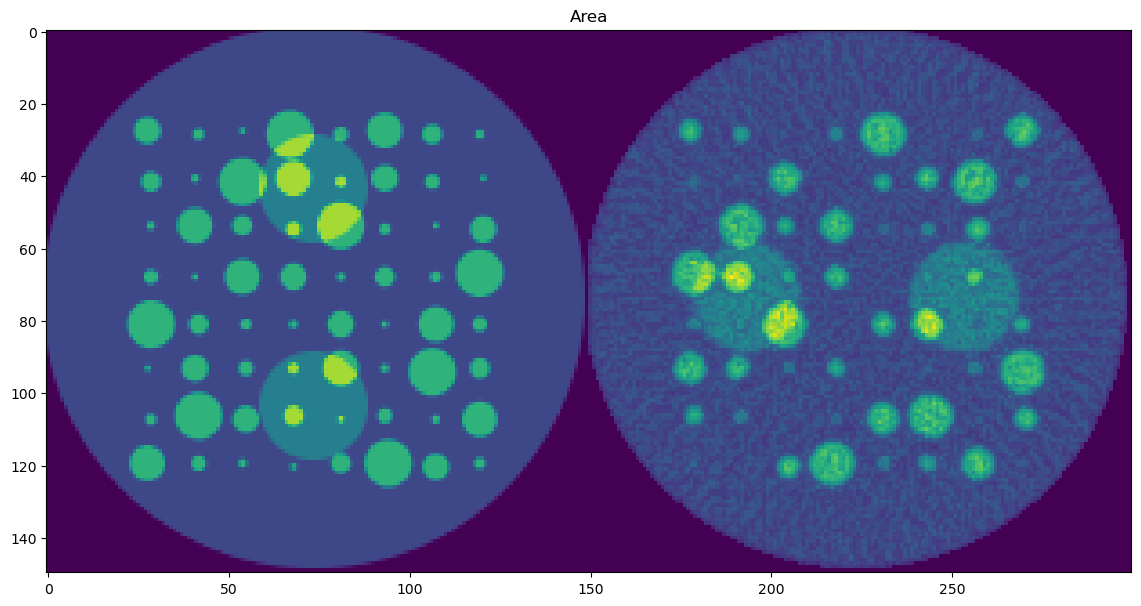

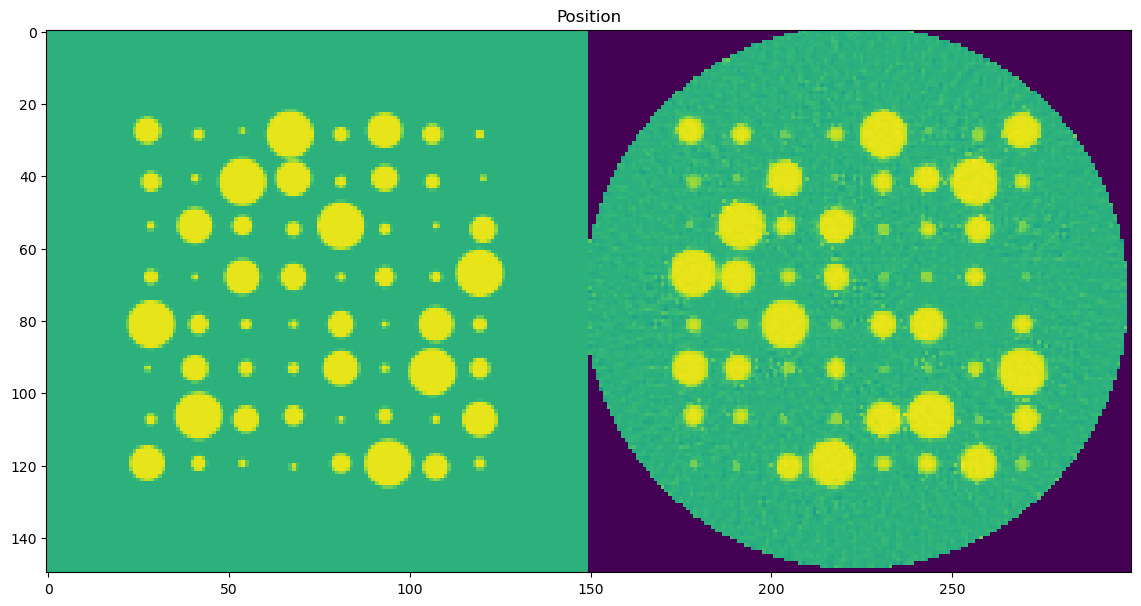

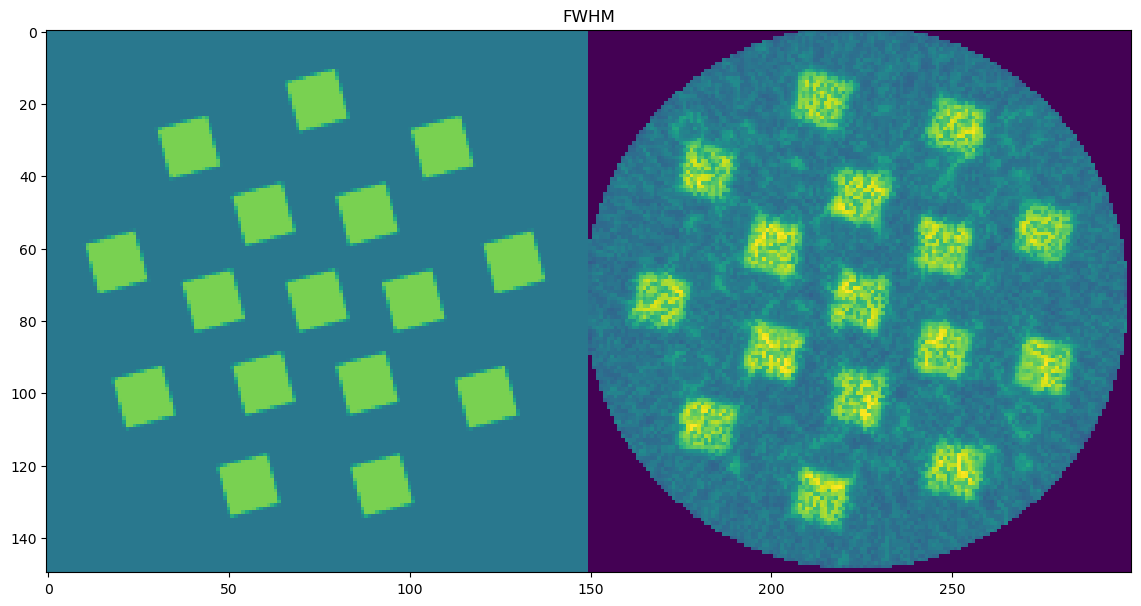

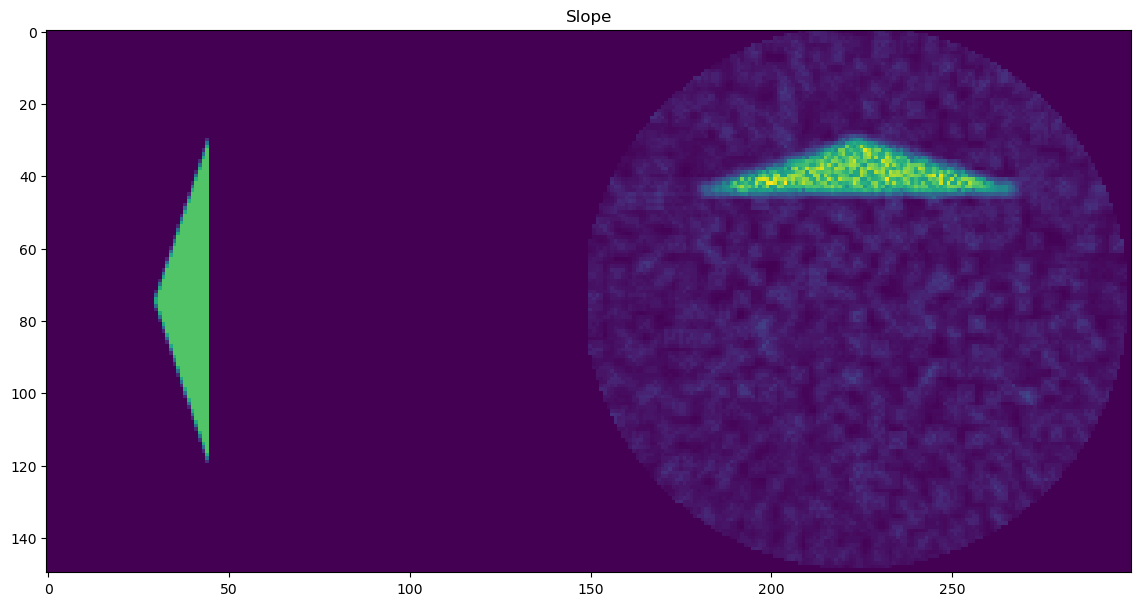

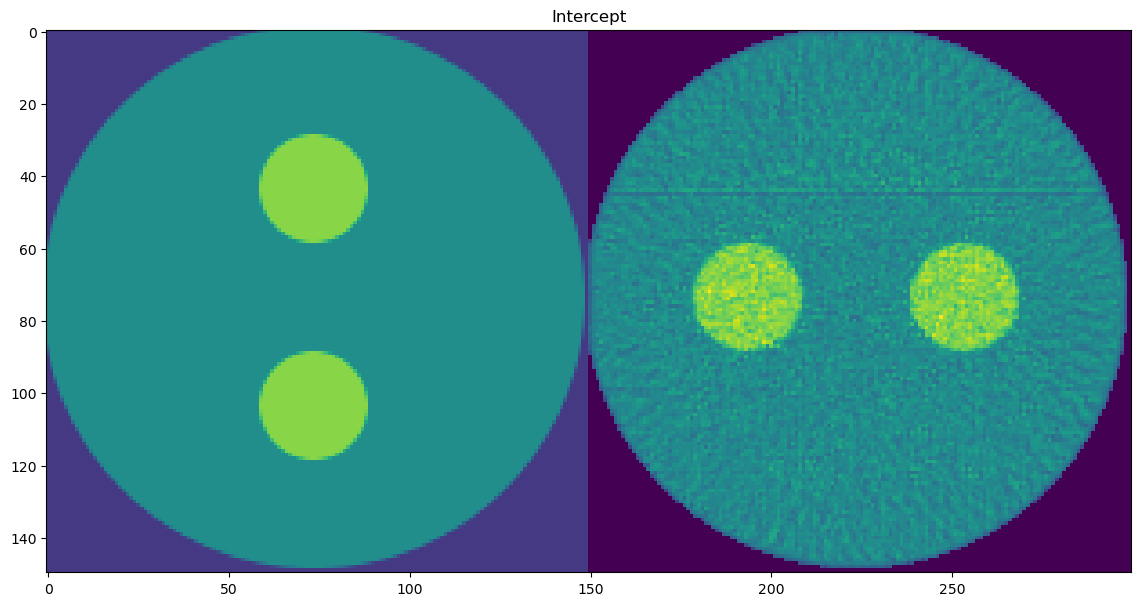

In [319]:
%matplotlib inline

ims = model(im_static)
filtered = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

prms_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
prms_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

print(prms_peak1_area.shape, prms_peak1_pos.shape, prms_peak1_fwhm.shape, prms_slope.shape, prms_intercept.shape)

print(peak_area.shape, peak_position.shape, peak_fwhm.shape, peak_slope.shape, peak_intercept.shape)


ofs = int((prms_peak1_area.shape[0] - peak_area.shape[0])/2)
print(ofs)

prms_peak1_area = prms_peak1_area[ofs:prms_peak1_area.shape[0]-ofs, ofs:prms_peak1_area.shape[1]-ofs]
prms_peak1_pos = prms_peak1_pos[ofs:prms_peak1_pos.shape[0]-ofs, ofs:prms_peak1_pos.shape[1]-ofs]
prms_peak1_fwhm = prms_peak1_fwhm[ofs:prms_peak1_fwhm.shape[0]-ofs, ofs:prms_peak1_fwhm.shape[1]-ofs]
prms_slope = prms_slope[ofs:prms_slope.shape[0]-ofs, ofs:prms_slope.shape[1]-ofs]
prms_intercept = prms_intercept[ofs:prms_intercept.shape[0]-ofs, ofs:prms_intercept.shape[1]-ofs]

print(prms_peak1_area.shape, prms_peak1_pos.shape, prms_peak1_fwhm.shape, prms_slope.shape, prms_intercept.shape)

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

areac = np.concatenate((peak_area, prms_peak1_area*msk), axis = 1)
posc = np.concatenate((peak_position, prms_peak1_pos*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm, prms_peak1_fwhm*msk), axis = 1)
slopec = np.concatenate((peak_slope, prms_slope*msk), axis = 1)
interceptc = np.concatenate((peak_intercept, prms_intercept*msk), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(areac)
# plt.colorbar()
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
plt.imshow(posc)
# plt.colorbar()
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
plt.imshow(fwhmc)
# plt.colorbar()
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
plt.imshow(slopec)
# plt.colorbar()
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
plt.imshow(interceptc)
# plt.colorbar()
plt.title('Intercept')
plt.show()

## 🧪 Final Comparison: Ground Truth vs FBP-Fit vs CNN (PeakFitCNN)

We now present a unified side-by-side visual comparison of the parameter maps produced by:
1. **Ground Truth** — from the original synthetic phantom
2. **FBP + Peak Fitting** — fitted using `PrmCNN2D` on the FBP-reconstructed volume
3. **PeakFitCNN** — directly predicted from 4× downsampled input using a self-supervised CNN

### 📌 Parameters Compared

- **Peak Area**
- **Peak Position**
- **Peak FWHM**
- **Background Slope**
- **Background Intercept**

Each subplot displays the three maps concatenated horizontally:
- **Left**: Ground truth (masked)
- **Middle**: FBP + peak fit (masked, transposed if needed)
- **Right**: PeakFitCNN (masked)

### 🔍 Purpose

This visualization enables direct assessment of:
- **Spatial fidelity**: How well each method recovers sharp features and gradients
- **Noise resilience**: Suppression of artefacts, especially in low-signal regions
- **Biases or smoothing effects** from CNN regularization or FBP artefacts

By comparing all approaches under the same visualization layout, we can appreciate the strengths and weaknesses of each pipeline.

In the next and final section, we’ll summarize key findings and reflect on implications for real-world XRD-CT analysis and future directions.

5


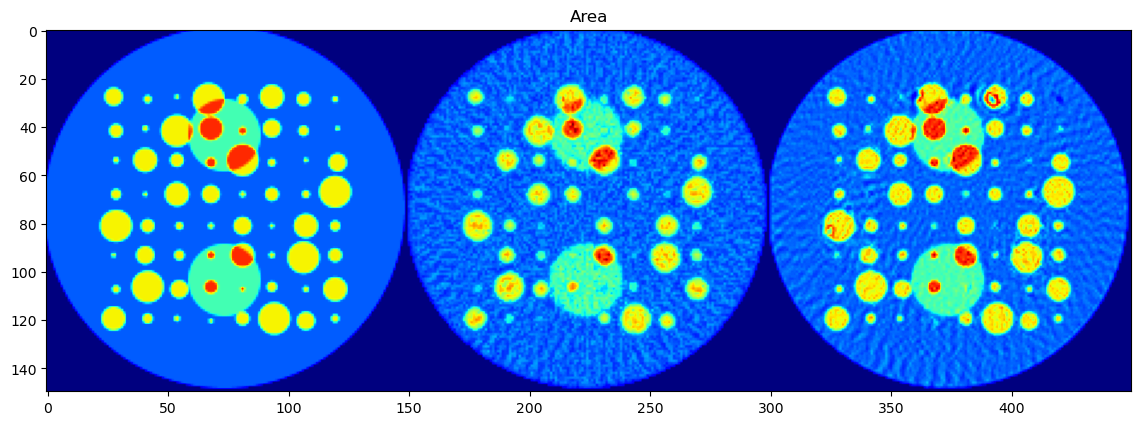

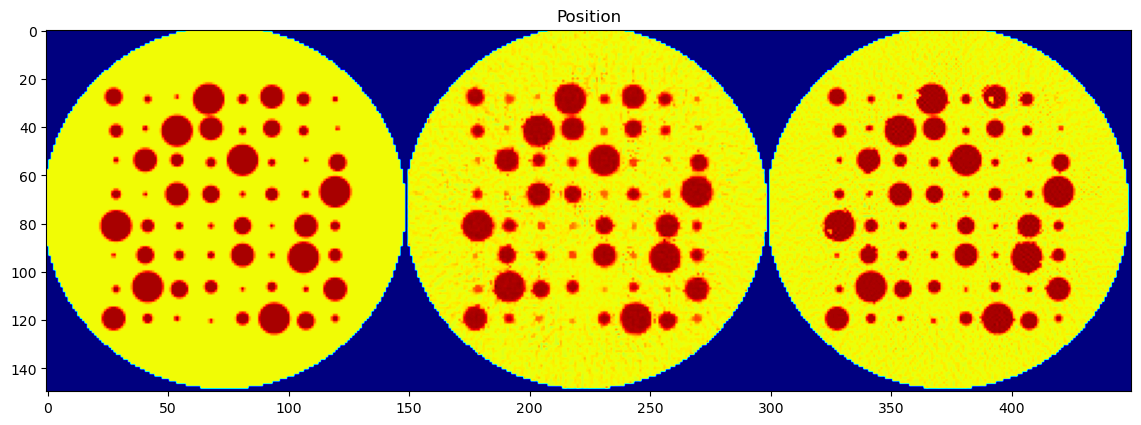

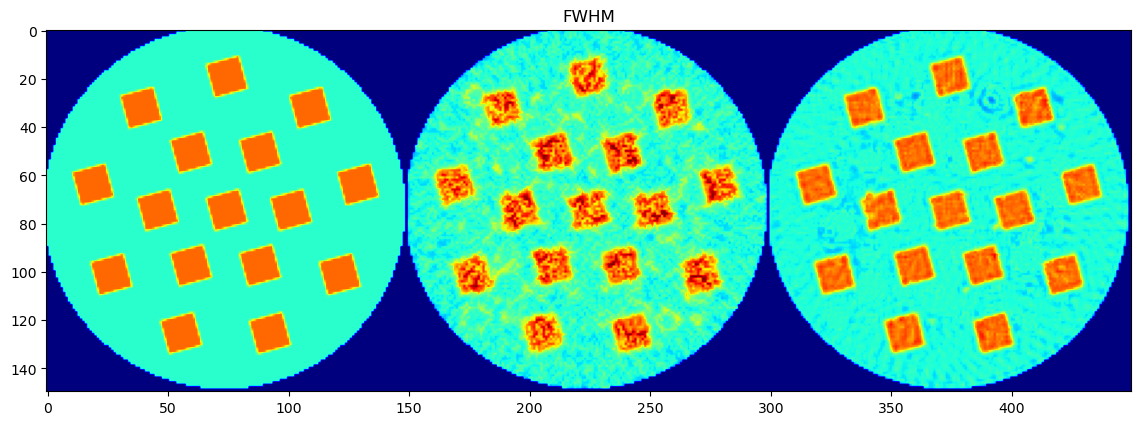

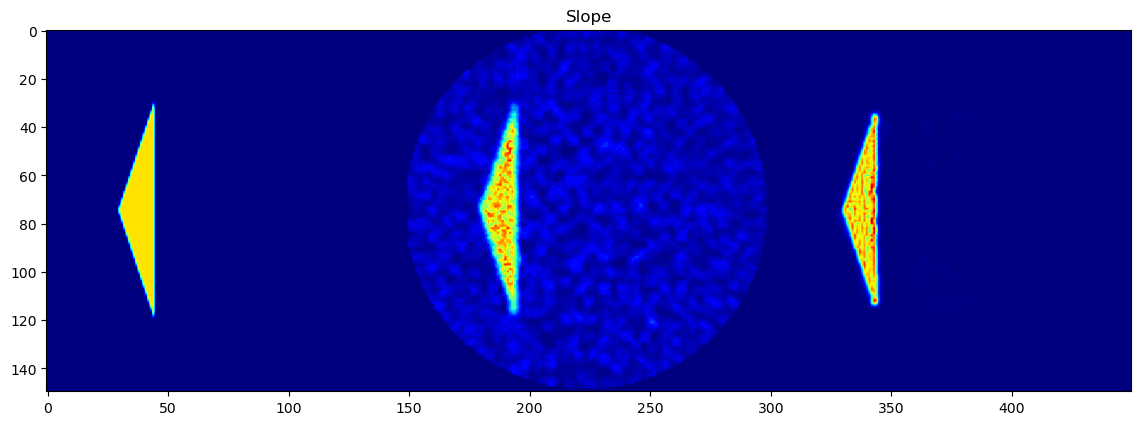

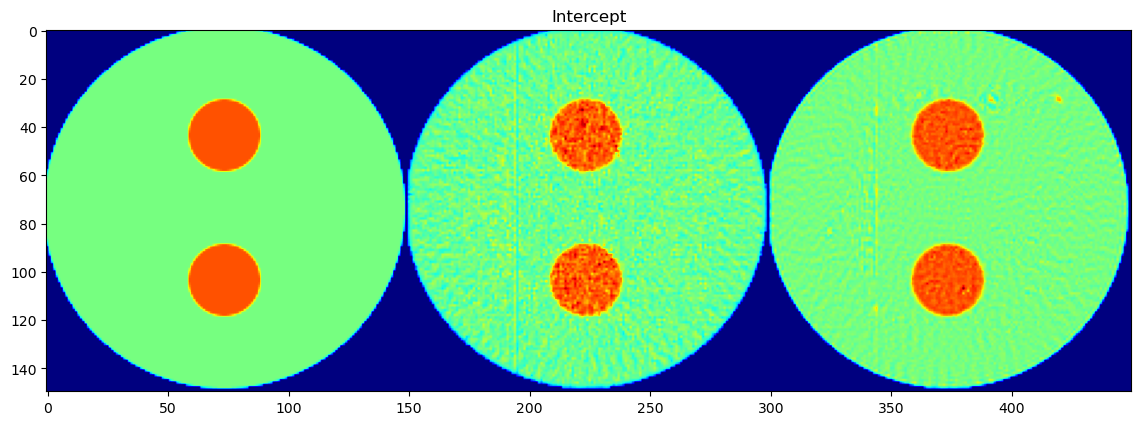

In [320]:
%matplotlib inline

ims = model_cnn(downsampled)

filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

cnn_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
cnn_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

ofs = int((cnn_peak1_area.shape[0] - peak_area.shape[0])/2)
print(ofs)

cnn_peak1_area = cnn_peak1_area[ofs:cnn_peak1_area.shape[0]-ofs, ofs:cnn_peak1_area.shape[1]-ofs]
cnn_peak1_pos = cnn_peak1_pos[ofs:cnn_peak1_pos.shape[0]-ofs, ofs:cnn_peak1_pos.shape[1]-ofs]
cnn_peak1_fwhm = cnn_peak1_fwhm[ofs:cnn_peak1_fwhm.shape[0]-ofs, ofs:cnn_peak1_fwhm.shape[1]-ofs]
cnn_slope = cnn_slope[ofs:cnn_slope.shape[0]-ofs, ofs:cnn_slope.shape[1]-ofs]
cnn_intercept = cnn_intercept[ofs:cnn_intercept.shape[0]-ofs, ofs:cnn_intercept.shape[1]-ofs]

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

areac = np.concatenate((peak_area*msk, np.transpose(prms_peak1_area)*msk, cnn_peak1_area*msk), axis = 1)
posc = np.concatenate((peak_position*msk, np.transpose(prms_peak1_pos)*msk, cnn_peak1_pos*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm*msk, np.transpose(prms_peak1_fwhm)*msk, cnn_peak1_fwhm*msk), axis = 1)
slopec = np.concatenate((peak_slope*msk, np.transpose(prms_slope)*msk, cnn_slope*msk), axis = 1)
interceptc = np.concatenate((peak_intercept*msk, np.transpose(prms_intercept)*msk, cnn_intercept*msk), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(areac, cmap = 'jet')
# plt.colorbar()
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
plt.imshow(posc, cmap = 'jet')
# plt.colorbar()
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
plt.imshow(fwhmc, cmap = 'jet')
# plt.colorbar()
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
plt.imshow(slopec, cmap = 'jet')
# plt.colorbar()
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
plt.imshow(interceptc, cmap = 'jet')
# plt.colorbar()
plt.title('Intercept')
plt.show()

## ✅ Final Remarks and Outlook

In this notebook, we explored and compared three distinct strategies for reconstructing peak parameter maps from hyperspectral XRD-CT data under angular undersampling conditions:

### 🧪 Summary of Approaches

| Method | Input | Output | Optimization |
|--------|-------|--------|--------------|
| **DLSR** | Noisy sinogram | Parameter maps | Self-supervised fit in parameter space |
| **FBP + Peak Fitting** | Reconstructed volume (FBP) | Parameter maps | Peak fitting via neural map regression |
| **PeakFitCNN** | Downsampled hyperspectral volume | Parameter maps | End-to-end self-supervised CNN |

### 📊 Key Findings

- **DLSR** provides physically consistent reconstructions and is resilient to angular undersampling. It explicitly models the forward projection, avoiding FBP artefacts.
- **PeakFitCNN** performs surprisingly well, achieving smooth and accurate maps with fewer learnable parameters and faster convergence. It benefits from spatial regularization via convolution.
- **FBP + Peak Fitting** shows reasonable accuracy but is sensitive to FBP artefacts, especially near boundaries or in low-signal regions. Its performance degrades more noticeably under sparse sampling.

### 💡 Contributions

- First **open-source PyTorch-based implementation** of the DLSR framework for XRD-CT
- Demonstrated the feasibility of using **neural networks instead of parameter maps** in DLSR
- Introduced **self-supervised CNN peak fitting** as a lightweight alternative, requiring no ground truth labels
- Provided a modular, reproducible benchmarking framework for XRD-CT reconstruction pipelines

### 🔭 Future Directions

- Extend to **multi-peak** and **asymmetric peak shapes** (e.g., Pseudo-Voigt or split-Voigt)
- Apply to **real experimental datasets**, especially where parallax or low-angle artefacts dominate
- Combine DLSR and CNN strategies in **hybrid architectures**, e.g., CNN-based priors in physics-constrained models

This work lays the groundwork for robust, interpretable, and scalable peak fitting in next-generation XRD-CT datasets. The integration of physics-based modeling and deep learning opens exciting opportunities for real-time, high-fidelity chemical imaging.